# EDA - HDB Resale

### Import Environment Modules and Data

In [1]:
### Import Python Modules

## System Modules
import sys
from typing import Union, Optional
import warnings

## Essential Modules
import numpy as np
import pandas as pd
from scipy.stats import randint
from scipy.stats import median_abs_deviation
import scipy.stats as st
import statsmodels.api as sm

## Graphical Modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Pipeline and Train Test Split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer

## SciKit Learning Preprocessing  
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

### SciKit Learn ML Models

## Linear Models
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import TransformedTargetRegressor

## Tree Based Linear Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


### Hyper-parameter Tuning

## GridSearch CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV # type: ignore

## explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV # type: ignore

## Optuna for Hyperparameter Tuning
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution


### Load Data

The following is a temporary placeholder. In a real end to end project, we need to connect to BigQuery and download the data from BigQuery using SQL extraction.

In [2]:
# Load the dataset
df = pd.read_csv('./data/hdb_resale_price.csv')

In [3]:
# give an indication on how large the dataset is
len(df)

211086

## Problem Statement

**We work for a property consultancy company. This company want to develop an end to end machine learning pipeline that could deliver housing price prediction to customer.**

**Our task is to develop a machine learning model that could accurately predict the resale prices of HDB resale flats. This model will assist buyers or sellers in planning their budgets more effectively and set realistic expectations. This model also need to help buyers determine the type of flat they can afford and in which location. This model also should provide sellers with valuable information regarding the potential market value of their property.**

## Basic Data Exploration

In [4]:
# Peek on the first 5 rows of the dataset
df.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

#### Detecting Duplicates

In [5]:
# check if there are any duplicates in the dataset
df.duplicated().sum()

np.int64(304)

**There are 304 duplicates.**

In [6]:
# Show the duplicates for visual inspection
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

month          town flat_type block     street_name storey_range  \
224     2017-01   BUKIT MERAH    4 ROOM   106  HENDERSON CRES     07 TO 09   
243     2017-01   BUKIT MERAH    4 ROOM   106  HENDERSON CRES     07 TO 09   
304     2017-01  CENTRAL AREA    3 ROOM   271        QUEEN ST     16 TO 18   
305     2017-01  CENTRAL AREA    3 ROOM   271        QUEEN ST     16 TO 18   
505     2017-01   JURONG EAST    4 ROOM   265     TOH GUAN RD     04 TO 06   
...         ...           ...       ...   ...             ...          ...   
201755  2025-05       HOUGANG    4 ROOM  994C   BUANGKOK LINK     10 TO 12   
210480  2025-05        YISHUN    4 ROOM  426B   YISHUN AVE 11     10 TO 12   
210483  2025-05        YISHUN    4 ROOM  426B   YISHUN AVE 11     10 TO 12   
205461  2025-06     SEMBAWANG    2 ROOM  103A     CANBERRA ST     04 TO 06   
205463  2025-06     SEMBAWANG    2 ROOM  103A     CANBERRA ST     04 TO 06   

        floor_area_sqm flat_model  lease_commence_date     remaining_lease  \
224               81.0   Improved                 1975            57 years   
243               81.0   Improved                 1975            57 years   
304               68.0   Improved                 1979  61 years 02 months   
305               68.0   Improved                 1979  61 years 02 months   
505              101.0    Model A                 1998  80 years 09 months   
...                ...        ...                  ...                 ...   
201755            93.0    Model A                 2021  94 years 09 months   
210480            92.0    Model A                 2015  88 years 11 months   
210483            92.0    Model A                 2015  88 years 11 months   
205461            38.0     2-room                 2020  94 years 07 months   
205463            38.0     2-room                 2020  94 years 07 months   

        resale_price  
224         470000.0  
243         470000.0  
304         470000.0  
305         470000.0  
505         470000.0  
...              ...  
201755      675000.0  
210480      595000.0  
210483      595000.0  
205461      350000.0  
205463      350000.0  

[607 rows x 11 columns]

**There could be two possible reasons for duplications. The first reason is duplicate submission to the system. The second reason is there is a very slim possibility that there could be a similar sales at the same location, same type, within the same 3 storey range and sell at a same price.**

In [7]:
# compute the percentage of duplicates in the dataset
duplicates_percentage = df.duplicated().sum() / len(df) * 100
print(f'The number of duplicates is {df.duplicated().sum()}, which is {duplicates_percentage:.2f}% of the entire dataset. ')

The number of duplicates is 304, which is 0.14% of the entire dataset. 


**Since duplicated data is less than 1% of the entire dataset, we will remove the duplicates as it would not have impacted our analysis or prediction.**

In [8]:
# Remove duplicates
df = df.drop_duplicates()

In [9]:
# check if there are any duplicates in the dataset for confirmation
df.duplicated().sum()

np.int64(0)

#### Detecting Missing Values

In [10]:
# check if there are any missing values in the dataset
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

**No missing values.**

### Data Structure Analysis

In [11]:
# display the information and data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210782 entries, 0 to 211085
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                210782 non-null  object 
 1   town                 210782 non-null  object 
 2   flat_type            210782 non-null  object 
 3   block                210782 non-null  object 
 4   street_name          210782 non-null  object 
 5   storey_range         210782 non-null  object 
 6   floor_area_sqm       210782 non-null  float64
 7   flat_model           210782 non-null  object 
 8   lease_commence_date  210782 non-null  int64  
 9   remaining_lease      210782 non-null  object 
 10  resale_price         210782 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 19.3+ MB


In [12]:
# Get numerical columns names and categorical columns names
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Print the numerical and categorical columns
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')
Categorical columns: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'remaining_lease'],
      dtype='object')


#### Data Anomaly Analysis for Numerical Columns

In [13]:
# anomaly analysis for numerical columns
df[numerical_columns].describe()

floor_area_sqm  lease_commence_date  resale_price
count   210782.000000        210782.000000  2.107820e+05
mean        96.860812          1996.336770  5.176226e+05
std         24.038202            14.241823  1.828416e+05
min         31.000000          1966.000000  1.400000e+05
25%         82.000000          1985.000000  3.800000e+05
50%         93.000000          1996.000000  4.850000e+05
75%        112.000000          2011.000000  6.200000e+05
max        366.700000          2022.000000  1.658888e+06

**There are no anaomaly, the minimum and maximum falls within expected range. For resale flat that has commencement date on 2022, there are some exception to the MOP rules especially for SERS holders.**

https://www.hdb.gov.sg/residential/living-in-an-hdb-flat/sers-and-upgrading-programmes/sers/sers-flat-owners/rehousing-options

#### Data Structure Anomaly Analysis for Categorical Columns

In [14]:
# check the unique values of the month column
df['month'].unique()

array(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
       '2023-07', '2023-08', '2023-09', '2023-10', 

**We can convert `month` to datetime format and convert it to year and month column. Then we set year as numeric and month as categorical.**

In [15]:
# check the unique values of the town column
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

**We can use one-hot encoding for town.**

In [16]:
# check the unique values of the flat_type column
df['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

**We can use ordinal encoding or one-hot encoding for flat_type.**

In [17]:
# check the unique values of the block column
df['block'].unique()

array(['406', '108', '602', ..., '478A', '479B', '479C'],
      shape=(2743,), dtype=object)

**We will use block number for future enhancement, for now we will remove them first.**

In [18]:
# check the unique values of the street_name column
df['street_name'].unique()

array(['ANG MO KIO AVE 10', 'ANG MO KIO AVE 4', 'ANG MO KIO AVE 5',
       'ANG MO KIO AVE 1', 'ANG MO KIO AVE 3', 'ANG MO KIO AVE 9',
       'ANG MO KIO AVE 8', 'ANG MO KIO AVE 6', 'ANG MO KIO ST 52',
       'BEDOK NTH AVE 4', 'BEDOK NTH AVE 1', 'BEDOK NTH RD',
       'BEDOK STH AVE 1', 'BEDOK RESERVOIR RD', 'CHAI CHEE ST',
       'BEDOK NTH ST 3', 'BEDOK STH RD', 'CHAI CHEE AVE',
       'NEW UPP CHANGI RD', 'CHAI CHEE DR', 'BEDOK STH AVE 2',
       'BEDOK NTH AVE 3', 'BEDOK RESERVOIR VIEW', 'CHAI CHEE RD',
       'LENGKONG TIGA', 'BEDOK CTRL', 'JLN DAMAI', 'BEDOK NTH AVE 2',
       'BEDOK STH AVE 3', 'SIN MING RD', 'SIN MING AVE', 'BISHAN ST 12',
       'BISHAN ST 13', 'BISHAN ST 22', 'BISHAN ST 24', 'BISHAN ST 23',
       'BRIGHT HILL DR', 'SHUNFU RD', 'BT BATOK ST 34', 'BT BATOK ST 51',
       'BT BATOK ST 11', 'BT BATOK ST 52', 'BT BATOK ST 21',
       'BT BATOK EAST AVE 5', 'BT BATOK WEST AVE 6', 'BT BATOK CTRL',
       'BT BATOK WEST AVE 8', 'BT BATOK EAST AVE 4', 'BT BATOK ST 3

**We will use street name for future enhancement, for now we will remove them first.**

In [19]:
# check the unique values of the storey_range column
df['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

**We can convert them to numerical number by taking the average between the 2 numbers.**

In [20]:
# check the unique values of the flat_model column
df['flat_model'].unique()

array(['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
       'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
       'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen'],
      dtype=object)

**We can use one-hot encoding for `flat_model`.**

In [21]:
# check the unique values of the remaining_lease column
df['remaining_lease'].unique()

array(['61 years 04 months', '60 years 07 months', '62 years 05 months',
       '62 years 01 month', '63 years', '61 years 06 months',
       '58 years 04 months', '59 years 08 months', '59 years 06 months',
       '60 years', '62 years 08 months', '61 years', '60 years 10 months',
       '59 years 03 months', '61 years 05 months', '60 years 04 months',
       '62 years', '60 years 03 months', '63 years 09 months',
       '61 years 01 month', '61 years 10 months', '58 years 06 months',
       '59 years 04 months', '62 years 11 months', '60 years 08 months',
       '93 years 08 months', '93 years 07 months', '60 years 01 month',
       '94 years 08 months', '78 years 04 months', '60 years 06 months',
       '62 years 06 months', '58 years', '70 years 08 months',
       '63 years 04 months', '63 years 06 months', '67 years 07 months',
       '61 years 07 months', '68 years 02 months', '68 years 03 months',
       '56 years', '67 years 09 months', '67 years 05 months',
       '63 years 07

**We can convert remaining lease from years and months into numerical months only.**

## Data Cleaning

**There are no data cleaning or imputation required before target and feature analysis. However, we will drop location features as these are not in our scope of analysis.**

In [22]:
categorical_columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'remaining_lease'],
      dtype='object')

In [23]:
# drop columns `block` and `street_name`
df = df.drop(columns=['block', 'street_name'])

In [24]:
# get numerical columns names
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')

In [25]:
# get categorical columns names
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['month', 'town', 'flat_type', 'storey_range', 'flat_model',
       'remaining_lease'],
      dtype='object')

## Target Analysis

In [26]:
# Resale price Date Range
end = df['month'].max() 
start = df['month'].min()
print(f'The resale price data starts from {start} and end on {end}')

The resale price data starts from 2017-01 and end on 2025-07


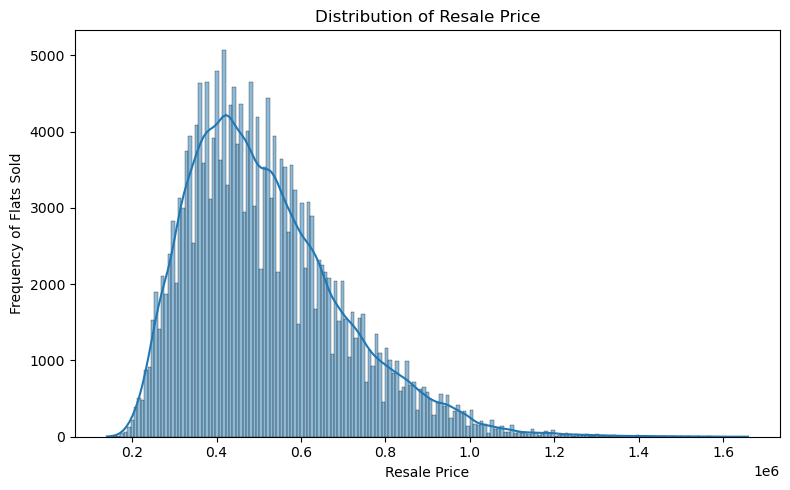

In [27]:
# Resale price distribution
fig, ax = plt.subplots(figsize=(8,5))  

sns.histplot(data=df, x='resale_price', kde=True, ax=ax)

ax.set_title('Distribution of Resale Price')
ax.set_xlabel('Resale Price')
ax.set_ylabel('Frequency of Flats Sold')

plt.tight_layout()
plt.show()

In [28]:
# display the statistical summary of the resale price
df['resale_price'].describe()

count    2.107820e+05
mean     5.176226e+05
std      1.828416e+05
min      1.400000e+05
25%      3.800000e+05
50%      4.850000e+05
75%      6.200000e+05
max      1.658888e+06
Name: resale_price, dtype: float64

In [29]:
# compute interquartile range of resale price
resale_price_iqr = df['resale_price'].quantile(0.75) - df['resale_price'].quantile(0.25)
resale_price_iqr

np.float64(240000.0)

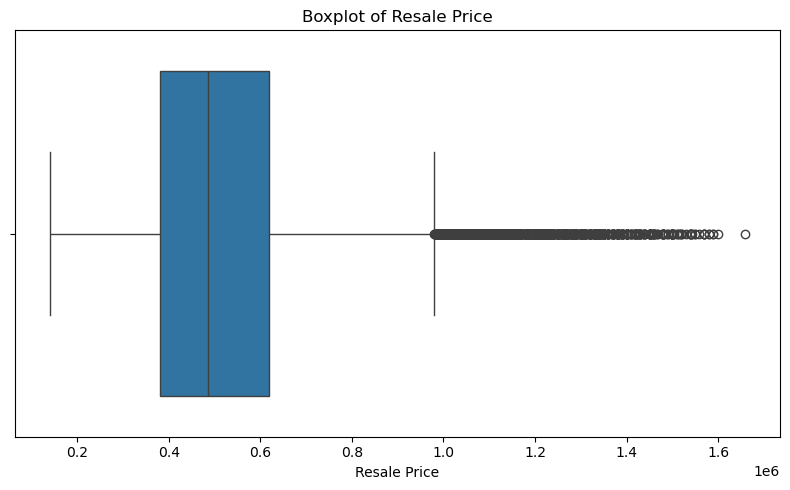

In [30]:
# boxplot the distribution of the resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='resale_price', vert=False)

ax.set_title('Boxplot of Resale Price')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

**The mean resale price is approximately $516K, while the median is about $485K. Transaction prices range from roughly $140K to $1.65M. The distribution is slightly right-skewed, indicating a tail of higher-priced flats. Lower-priced units cluster more tightly around the median. A standard deviation of about $182K shows how much prices typically deviate from the mean. The interquartile range (middle 50 % of transactions) is roughly $240K.**

### Skewness Analysis

In [31]:
# Compute skewness of resale price
skewness = df['resale_price'].skew()
print(f"Skewness of Resale Price: {skewness:.2f}")
if skewness > 0.5: # type: ignore[arg-type]
    print("The distribution is positively skewed.")
elif skewness < -0.5: # type: ignore[arg-type]
    print("The distribution is negatively skewed.")
else:
    print("The distribution is approximately symmetric.")

# Compute kurtosis of resale price
kurtosis = df['resale_price'].kurt()
print(f"Kurtosis of Resale Price: {kurtosis:.2f}")
if kurtosis > 3: # type: ignore[arg-type]
    print("The distribution is leptokurtic.")
elif kurtosis < 3: # type: ignore[arg-type]
    print("The distribution is platykurtic.")
else:
    print("The distribution is mesokurtic.")

Skewness of Resale Price: 0.94
The distribution is positively skewed.
Kurtosis of Resale Price: 1.14
The distribution is platykurtic.


**Based on a skewness of 0.95, the HDB resale-price distribution is moderately right-skewed, indicating some high-price outliers are pulling the mean above the median. Although below 1.0, this skewness can still affect models that assume normal residuals, so we should check residual plots (e.g., residuals vs. fitted, Q–Q) and consider a log or Box–Cox transformation if needed.**

**With a kurtosis of 1.15 (< 3), the distribution is platykurtic, meaning it’s flatter-topped with thinner tails than a normal curve—there are less extreme values since the tail is thinner than those under Gaussian assumptions**

**Together, these measures reveal a fairly even spread of resale prices with a moderate right tail. For predictive modeling, we recommend running residual diagnostics and experimenting with a log(price) transform or robust regression techniques to ensure our assumptions hold.**

https://www.investopedia.com/terms/p/platykurtic.asp#:~:text=The%20term%20%22platykurtic%22%20refers%20to,extreme%20positive%20or%20negative%20events.

### Outliers Analysis

In [32]:
# outliers detection using IQR 
resale_price_iqr_q1 = df['resale_price'].quantile(0.25)
resale_price_iqr_q3 = df['resale_price'].quantile(0.75)

resale_price_iqr_outliers_left = df[(df['resale_price'] < resale_price_iqr_q1 - 1.5 * resale_price_iqr)]
print(f'The number of outliers (IQR) in the left distribution of resale price is {len(resale_price_iqr_outliers_left)}')
resale_price_iqr_outliers_right = df[(df['resale_price'] > resale_price_iqr_q3 + 1.5 * resale_price_iqr)]
print(f'The number of outliers (IQR) in the right distribution of resale price is {len(resale_price_iqr_outliers_right)}')

resale_price_iqr_outliers = pd.concat([resale_price_iqr_outliers_left,resale_price_iqr_outliers_right], ignore_index=True, axis=0)
print(f'The total number of outliers (IQR) in the resale price is {len(resale_price_iqr_outliers)}')

# percentage of outliers in the resale price
resale_price_iqr_outliers_percentage = len(resale_price_iqr_outliers) / len(df) * 100
print(f'Total number of transactions is {len(df)}')
print(f'The percentage of outliers (IQR) in the resale price is {resale_price_iqr_outliers_percentage:.2f}%')

The number of outliers (IQR) in the left distribution of resale price is 0
The number of outliers (IQR) in the right distribution of resale price is 3738
The total number of outliers (IQR) in the resale price is 3738
Total number of transactions is 210782
The percentage of outliers (IQR) in the resale price is 1.77%


In [33]:
# outliers detection using Z-score
resale_price_z_score = (df['resale_price'] - df['resale_price'].mean()) / df['resale_price'].std()
resale_price_z_score_threshold = 3
resale_price_z_score_outliers_left = df[resale_price_z_score < np.negative(resale_price_z_score_threshold)]
print(f'The number of outliers (z-score) in the left distribution of resale price is {len(resale_price_z_score_outliers_left)}')
resale_price_z_score_outliers_right = df[resale_price_z_score > resale_price_z_score_threshold]
print(f'The number of outliers (z-score) in the right distribution of resale price is {len(resale_price_z_score_outliers_right)}')

resale_price_z_score_outliers = pd.concat([resale_price_z_score_outliers_left, resale_price_z_score_outliers_right], axis=0, ignore_index=True)
print(f'The total number of outliers (z-score) in the resale price is {len(resale_price_z_score_outliers)}')

# percentage of outliers in the resale price
resale_price_z_score_outliers_percentage = len(resale_price_z_score_outliers) / len(df) * 100
print(f'Total number of transactions is {len(df)}')
print(f'The percentage of outliers (z-score) in the resale price is {resale_price_z_score_outliers_percentage:.2f}%')

The number of outliers (z-score) in the left distribution of resale price is 0
The number of outliers (z-score) in the right distribution of resale price is 1791
The total number of outliers (z-score) in the resale price is 1791
Total number of transactions is 210782
The percentage of outliers (z-score) in the resale price is 0.85%


**Using IQR method, there are 1.74% of transactions lie beyond 1.5 times of the third quartiles, so extreme HDB resale prices are fairly uncommon but not very rare.**

**Using z-score method, there are 0.84% of transactions lie beyond +3 $\sigma$. Compared to a Gaussian distribution, where 0.27% of data lies beyond ±3 σ, this 0.84% indicates a heavier right tail than expected under normal assumptions, suggesting the presence of significant high-value transactions, despite the overall platykurtic nature of the distribution (which implies thinner tails in general compared to a normal curve).** 

**The reason, z-score method detect less outliers because extreme values impacted its means and standard deviation. With elevated means and standard deviation, z-score method is only able to detect very extreme values. In a skewed distribution, the better method is using IQR method, as it is less sensitive to outliers. We will be adopting the percentage of outliers as 1.74% based on IQR method.**

In [34]:
# Descriptive statistics of outliers
print("Descriptive statistics of detected outliers:")
print(resale_price_iqr_outliers['resale_price'].describe())

Descriptive statistics of detected outliers:
count    3.738000e+03
mean     1.099328e+06
std      1.166306e+05
min      9.800880e+05
25%      1.010000e+06
50%      1.060000e+06
75%      1.150000e+06
max      1.658888e+06
Name: resale_price, dtype: float64


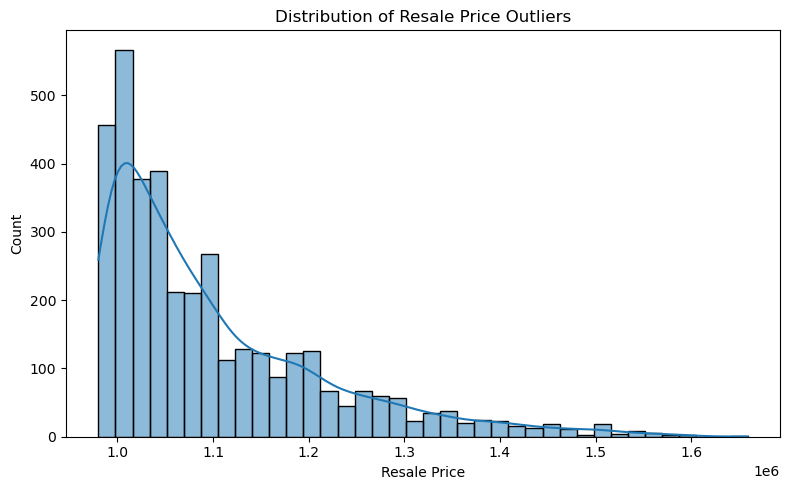

In [35]:
# plot the distribution of the outliers of resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.histplot(data=resale_price_iqr_outliers, x='resale_price', kde=True)


ax.set_title('Distribution of Resale Price Outliers')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

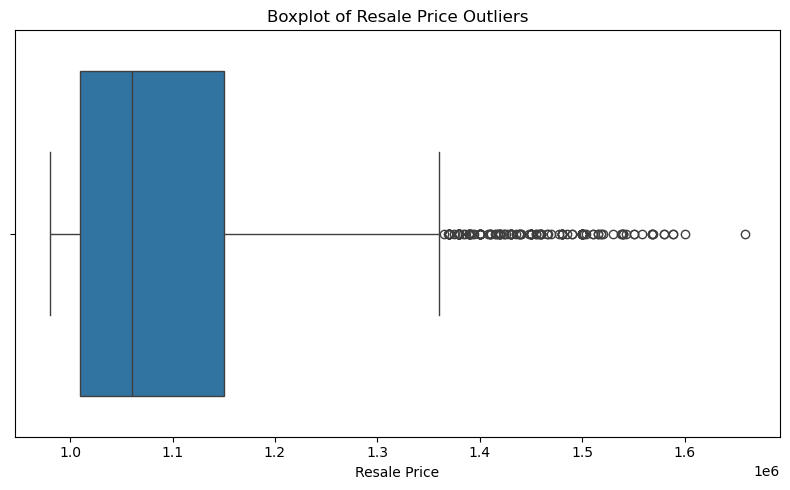

In [36]:
# boxplot the distribution of the outliers of resale price
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=resale_price_iqr_outliers, x='resale_price', vert=False)


ax.set_title('Boxplot of Resale Price Outliers')
ax.set_xlabel('Resale Price')

plt.tight_layout()
plt.show()

**Even among the 3,643 detected outliers, the distribution of resale prices is right-skewed (mean $1.098M vs. median $1.06M). This indicates that within this outlier segment, there are still a few significantly higher-value transactions that exert disproportional influence on this segment's mean and standard deviation.**

**These most extreme transactions within the outlier group are the ones that will have the greatest impact on the overall mean and standard deviation of the full HDB resale price dataset.** 

#### Million Dollar Flats by Year (Outliers in Layman Conext)

In [37]:
# Compute million dollars flats by year using a separate df
million_dollars_flats = df[df['resale_price'] >= 1000000].copy()
million_dollars_flats['month'] = pd.to_datetime(million_dollars_flats['month'])
million_dollars_flats['year'] = million_dollars_flats['month'].dt.year
million_dollars_flats_by_year = million_dollars_flats.groupby('year').size()
million_dollars_flats_by_year


year
2017      46
2018      71
2019      64
2020      82
2021     259
2022     369
2023     468
2024    1035
2025     824
dtype: int64

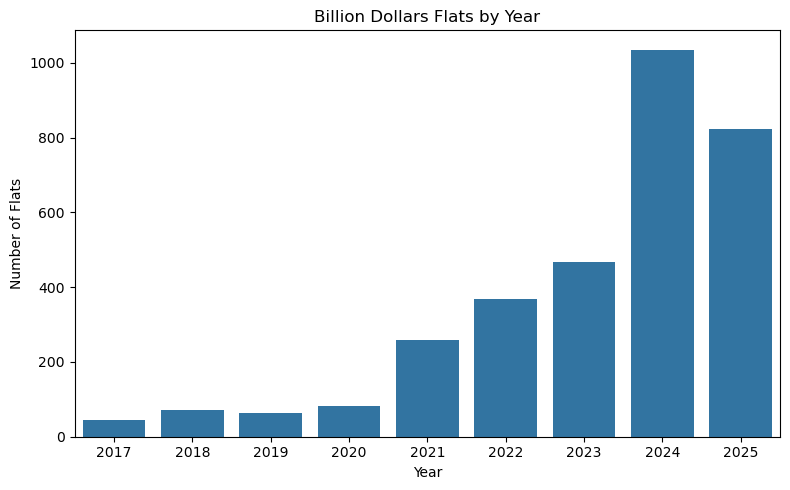

In [38]:
# plot the million dollars flats by year
fig, ax = plt.subplots(figsize=(8,5))  

sns.barplot(x=million_dollars_flats_by_year.index, y=million_dollars_flats_by_year.values)

ax.set_title('Billion Dollars Flats by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Flats')

plt.tight_layout()
plt.show()


In [39]:
million_dollars_flats.loc[million_dollars_flats['resale_price'].sort_values(ascending=False).index]

month          town flat_type storey_range  floor_area_sqm  \
205379 2025-06-01    QUEENSTOWN    5 ROOM     22 TO 24           122.0   
209050 2025-01-01     TOA PAYOH    5 ROOM     19 TO 21           117.0   
174503 2024-06-01   BUKIT MERAH    5 ROOM     34 TO 36           112.0   
174551 2024-06-01   BUKIT MERAH    5 ROOM     46 TO 48           113.0   
200256 2025-06-01  CENTRAL AREA    5 ROOM     34 TO 36           105.0   
...           ...           ...       ...          ...             ...   
201307 2025-01-01       GEYLANG    4 ROOM     13 TO 15            93.0   
8210   2017-06-01        BISHAN    5 ROOM     19 TO 21           120.0   
103001 2021-07-01    QUEENSTOWN    5 ROOM     10 TO 12           104.0   
138878 2022-03-01     TOA PAYOH    5 ROOM     25 TO 27           110.0   
164906 2023-06-01     TOA PAYOH    4 ROOM     34 TO 36            93.0   

                    flat_model  lease_commence_date     remaining_lease  \
205379  Premium Apartment Loft                 2016  89 years 11 months   
209050                    DBSS                 2012  86 years 06 months   
174503                Improved                 2016  90 years 08 months   
174551                Improved                 2019            94 years   
200256                 Type S2                 2011  84 years 08 months   
...                        ...                  ...                 ...   
201307                 Model A                 2020  94 years 06 months   
8210                      DBSS                 2011  93 years 03 months   
103001       Premium Apartment                 2016  94 years 02 months   
138878                Improved                 2009  86 years 02 months   
164906                 Model A                 2018  94 years 03 months   

        resale_price  year  
205379     1658888.0  2025  
209050     1600000.0  2025  
174503     1588000.0  2024  
174551     1588000.0  2024  
200256     1580000.0  2025  
...              ...   ...  
201307     1000000.0  2025  
8210       1000000.0  2017  
103001     1000000.0  2021  
138878     1000000.0  2022  
164906     1000000.0  2023  

[3218 rows x 10 columns]

Base on the outliers analysis above, we have the following strategies:

**Method 1 : Transform the target (or rely on Huber regression)**

Apply a log or Box-Cox transform so resale prices approximate a normal distribution. This stabilizes variance and usually trims RMSE, but back-transforming compresses the right tail, so million-dollar flats are systematically under-predicted. Skipping the transform and fitting a Huber regressor instead keeps the target in dollars while down-weighting extreme residuals via its piece-wise (quadratic ↦ linear) loss.

<sub>Refs: Box & Cox 1964; Huber 1964.</sub>

**Method 2 : Winsorise the most extreme outliers**

Cap, rather than delete, the top (say) 0.5 % of sale prices at the 99.5th percentile. Our leverage plot shows a handful of points far beyond the main tail; capping them removes their undue influence while preserving rank information.

<sub>Ref: Tukey 1962.</sub>

**Method 3: Segment the market and fit specialized models**

Train a classifier that flags "premium-location" transactions (e.g. postal code, distance to CBD). Fit separate regressors for the luxury and mainstream segments, then stack or blend their predictions. The luxury regressor can learn high-end drivers (view corridor, penthouse level) that a single global model would treat as noise.

<sub>Ref: Breiman 1996, “Stacked Regressions”.</sub>

**Method 4: Quantile regression**

Minimize the pinball loss at chosen quantiles (e.g. 50th, 90th). Because the method doesn’t assume Gaussian errors, it is naturally robust to heavy tails and produces prediction intervals without bootstrapping.

<sub>Ref: Koenker & Bassett 1978.</sub>

**Tree-based ensembles (Random Forest, Gradient Boosting, XGBoost/LightGBM)**

Decision trees split on features, so a handful of ultra-high prices are isolated in tiny terminal nodes instead of skewing every split. Ensembles average (Random Forest) or stage-wise correct (GBM) those trees, giving high bias-variance control and built-in outlier tolerance.

Pros:
- Capture complex non-linearities and interactions without manual feature engineering.
- Handle heterogeneous variance (“price heteroskedasticity”) gracefully.

Cons:
- Still optimize squared-error inside each leaf, so extreme targets inside the same leaf can inflate loss; tune max_depth and min_samples_leaf to avoid this.
- Feature importance can be biased toward high-cardinality categorical splits; apply permutation importance or SHAP to audit.

<sub>Refs: Breiman 2001 (Random Forest); Friedman 2001 (GBM); Chen & Guestrin 2016 (XGBoost); Ke et al. 2017 (LightGBM).</sub>

**We will perform the aforementioned methods during model selection.**

## Feature Analysis (Univariate)

In [40]:
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price'], dtype='object')

In [41]:
numerical_columns = numerical_columns[:2]
numerical_columns

Index(['floor_area_sqm', 'lease_commence_date'], dtype='object')

In [42]:
def plot_numerical_column(df: pd.DataFrame, each_column: str):
    """    Feature Analysis of Numerical Columns
    """
    print('========================================')
    print('Feature Analysis of', each_column)
    print('========================================')
    print(df[each_column].describe())

    # plot the distribution of the column
    fig, ax = plt.subplots(figsize=(8,5)) 
    sns.histplot(data=df, x=each_column, kde=True)
    
    ax.set_title(f'Distribution of {each_column}')
    ax.set_xlabel(each_column)
    ax.set_ylabel('Frequency')
    plt.show()

    # Compute skewness of floor_area_sqm
    skewness = df[each_column].skew()
    print(f"Skewness of {each_column}: {skewness:.2f}")
    if skewness > 0.5: # type: ignore[arg-type]
        print("The distribution is positively skewed.")
    elif skewness < -0.5: # type: ignore[arg-type]
        print("The distribution is negatively skewed.")
    else:
        print("The distribution is approximately symmetric.")

    # Compute kurtosis of resale price
    kurtosis = df[each_column].kurt()
    print(f"Kurtosis of {each_column}: {kurtosis:.2f}")
    if kurtosis > 3: # type: ignore[arg-type]
        print("The distribution is leptokurtic.")
    elif kurtosis < 3: # type: ignore[arg-type]
        print("The distribution is platykurtic.")
    else:
        print("The distribution is mesokurtic.")
    


#### Numerical Feature Column: Floor Area (square meters)

Feature Analysis of floor_area_sqm
count    210782.000000
mean         96.860812
std          24.038202
min          31.000000
25%          82.000000
50%          93.000000
75%         112.000000
max         366.700000
Name: floor_area_sqm, dtype: float64


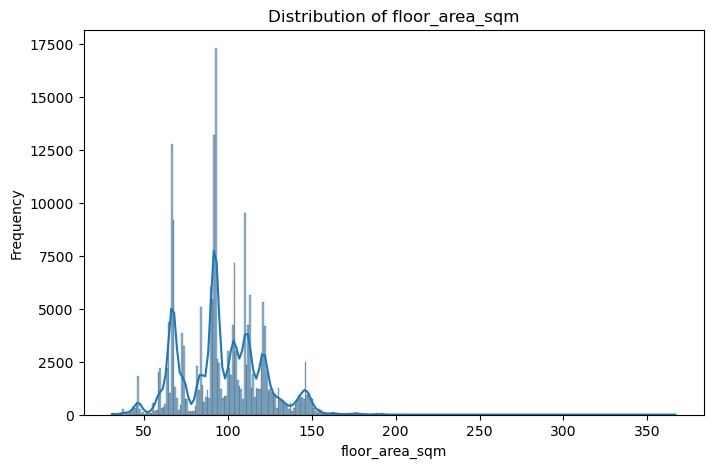

Skewness of floor_area_sqm: 0.26
The distribution is approximately symmetric.
Kurtosis of floor_area_sqm: 0.01
The distribution is platykurtic.


In [43]:
plot_numerical_column(df, 'floor_area_sqm')

**While the skewness of `floor_area_sqm` is low at 0.26, statistically suggesting an approximately symmetric distribution, visual inspection of the data reveals a long extension to the very right, with a maximum value of 366.7 sqm significantly higher than the 75th percentile of 112 sqm.**

**The relatively low skewness, despite this visible right tail, is likely due to the bulk of the distribution being quite symmetric around its central tendency, thus tempering the overall skewness metric. Furthermore, the likely multimodal nature of floor_area_sqm (reflecting distinct HDB flat types/sizes, such as 3-room, 4-room, 5-room, and executive flats) also contributes to lowering the aggregate skewness.**

**For linear regression models, we will not apply a direct transformation to floor_area_sqm based on its low overall skewness. However, we will carefully examine residual plots to ensure assumptions of linearity and homoscedasticity hold, as the long right tail and distinct modes could still subtly influence model behavior.**

**Conversely, tree-based models (such as Random Forest or Gradient Boosting) are inherently well-suited to handle multimodal feature distributions without requiring explicit transformations. Their ability to make splits based on thresholds allows them to naturally segment and learn from distinct peaks in the data.**

#### Categorical Feature Column: Lease Commence Date

Feature Analysis of lease_commence_date
count    210782.000000
mean       1996.336770
std          14.241823
min        1966.000000
25%        1985.000000
50%        1996.000000
75%        2011.000000
max        2022.000000
Name: lease_commence_date, dtype: float64


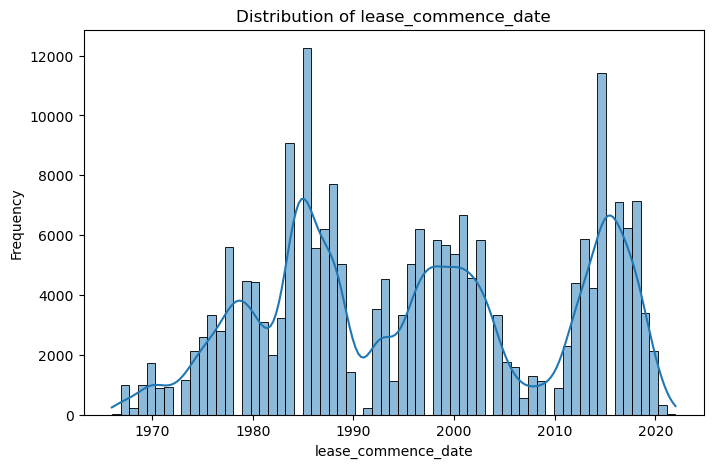

Skewness of lease_commence_date: 0.07
The distribution is approximately symmetric.
Kurtosis of lease_commence_date: -1.17
The distribution is platykurtic.


In [44]:
plot_numerical_column(df, 'lease_commence_date')

**Skewness of `lease_commerce_date` is low at 0.07, suggesting an symmetric distribution. Visual inspection of the chart reveals a multimodal distributions.**

**We will consider tree-based models (such as Random Forest or Gradient Boosting) are inherently well-suited to handle multimodal feature distributions.**

### Categorical Columns

In [45]:
categorical_columns

Index(['month', 'town', 'flat_type', 'storey_range', 'flat_model',
       'remaining_lease'],
      dtype='object')

In [46]:
def plot_categorical_column(df: pd.DataFrame, column_name: str, rare_threshold: float = 0.01): # 0.01 (1%) is the default threshold for rare values
    """
    Display the statistics of the column
    Countplot of the column sorted by the value counts with highest value counts on top (horizontal view)
    Value counts sorted by the value counts with weights in percentage
    """
    # Display the column name
    print('========================================')
    print(column_name)
    print('--------------------------------')

    # Display the statistics of the column
    print(f'{column_name} describe:')
    print(df[column_name].describe())

    print('--------------------------------')
    # countplot of the column sorted by the value counts with highest value counts on top
    fig, ax = plt.subplots(figsize=(8,5))  

    sns.set_style("whitegrid")
    sns.countplot(data=df, y=column_name, order=df[column_name].value_counts().index)

    ax.set_title(f'Count of {column_name}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column_name)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 90)

    plt.tight_layout()
    plt.show()

    # Display the value counts with percentage
    value_counts = df[column_name].value_counts(dropna=False)
    value_counts_percentage = value_counts/len(df[column_name])
    value_count_rare_df = pd.DataFrame({
        "value_count"   : value_counts,
        "percent" : value_counts_percentage
    })
    value_count_rare_df["is_rare"] = value_count_rare_df["percent"] < rare_threshold

    print('--------------------------------')
    print(f'Rare threshold of {rare_threshold * 100}%')
    print(value_count_rare_df)
    print('========================================')

#### Categorical Feature Column: Month

month
--------------------------------
month describe:
count      210782
unique        103
top       2024-07
freq         3036
Name: month, dtype: object
--------------------------------


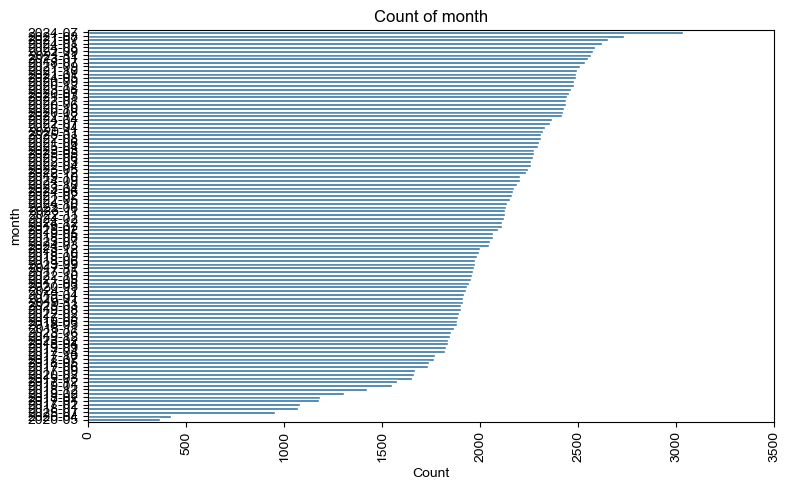

--------------------------------
Rare threshold of 1.0%
         value_count   percent  is_rare
month                                  
2024-07         3036  0.014404    False
2021-08         2735  0.012975    False
2021-07         2655  0.012596    False
2024-01         2620  0.012430    False
2024-08         2588  0.012278    False
...              ...       ...      ...
2017-02         1080  0.005124     True
2018-01         1072  0.005086     True
2025-07          952  0.004517     True
2020-04          423  0.002007     True
2020-05          363  0.001722     True

[103 rows x 3 columns]


In [47]:
plot_categorical_column(df,'month')

**The feature `month`, need to convert to datetime format. However, ML models could not interpret datetime, therefore we need to convert them to numerical features in `transaction_year` and `transaction_month`. We will use `transaction_year` as ordinal numerical features. For `transaction_month`, this is seasonal, therefore we can either use one-hot encoding or cyclic sine/cosine pair (two columns that preserve the circular nature).**

**To simplified feature engineering, we will use one-hot encoding for `transaction_month`.**

In [48]:
def convert_month_to_year_month(df: pd.DataFrame, 
                              month: str = 'month',
                              transaction_year: str = 'transaction_year',
                              transaction_month: str = 'transaction_month') -> pd.DataFrame:
    """
    Convert month column to separate year and month columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing the month column
    month : str, default 'month'
        Name of the column containing month data
    transaction_year : str, default 'transaction_year'
        Name of the output year column
    month_out_col : str, default 'transaction_month'
        Name of the output month column
    
    Returns:
    --------
    pd.DataFrame
        Modified dataframe
    
    Raises:
    -------
    ValueError
        If month_col doesn't exist in the dataframe
    TypeError
        If df is not a pandas DataFrame
    """
    
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    # Check if dataframe is empty
    if df.empty:
        warnings.warn("Input dataframe is empty", UserWarning)
        return df.copy()
    
    # Check if month column exists
    if month not in df.columns:
        raise ValueError(f"Column '{month}' not found in dataframe")
    
    # Work on copy
    df = df.copy()
    
    # Convert to datetime with error handling
    try:
        df[month] = pd.to_datetime(df[month])
    except (ValueError, TypeError) as e:
        raise ValueError(f"Cannot convert column '{month}' to datetime: {str(e)}")
    
    # Extract year and month
    df[transaction_year] = df[month].dt.year
    df[transaction_month] = df[month].dt.month
    
    # Return dataframe
    return df

In [49]:
# =============================================================================
# SIMPLE TESTS - Run these in your notebook
# =============================================================================

def test_basic_functionality():
    """Test that the function works with normal data"""
    # Create test data
    test_df = pd.DataFrame({
        'month': ['2023-01-15', '2023-02-20', '2023-03-10'],
        'value': [100, 200, 300]
    })
    
    # Run function
    result = convert_month_to_year_month(test_df)
    
    # Check results
    assert 'transaction_year' in result.columns
    assert 'transaction_month' in result.columns
    assert result['transaction_year'].tolist() == [2023, 2023, 2023]
    assert result['transaction_month'].tolist() == [1, 2, 3]
    
    print("✓ Basic functionality test passed!")


test_basic_functionality()

✓ Basic functionality test passed!


In [50]:

def test_different_date_formats():
    """Test with different date formats"""
    test_df = pd.DataFrame({
        'month': ['2023-01', '2023-02', '2023-03'],
        'value': [100, 200, 300]
    })
    
    result = convert_month_to_year_month(test_df)
    
    assert result['transaction_year'].iloc[0] == 2023
    assert result['transaction_month'].iloc[0] == 1
    
    print("✓ Different date formats test passed!")

test_different_date_formats()

✓ Different date formats test passed!


In [51]:

def test_with_nulls():
    """Test with null values"""
    test_df = pd.DataFrame({
        'month': ['2023-01-15', None, '2023-03-10'],
        'value': [100, 200, 300]
    })
    
    result = convert_month_to_year_month(test_df)
    
    # First and third rows should work
    assert result['transaction_year'].iloc[0] == 2023
    assert result['transaction_month'].iloc[0] == 1
    
    print("✓ Null values test passed!")

test_with_nulls()

✓ Null values test passed!


In [52]:

def test_original_unchanged():
    """Test that original dataframe is not modified"""
    original_df = pd.DataFrame({
        'month': ['2023-01-15', '2023-02-20'],
        'value': [100, 200]
    })
    
    # Store original state
    original_columns = original_df.columns.tolist()
    
    # Run function
    result = convert_month_to_year_month(original_df)
    
    # Check original is unchanged
    assert original_df.columns.tolist() == original_columns
    assert 'transaction_year' not in original_df.columns
    
    # Check result has new columns
    assert 'transaction_year' in result.columns
    
    print("✓ Original unchanged test passed!")

test_original_unchanged()

✓ Original unchanged test passed!


#### Categorical Feature Column: Town

town
--------------------------------
town describe:
count       210782
unique          26
top       SENGKANG
freq         17295
Name: town, dtype: object
--------------------------------


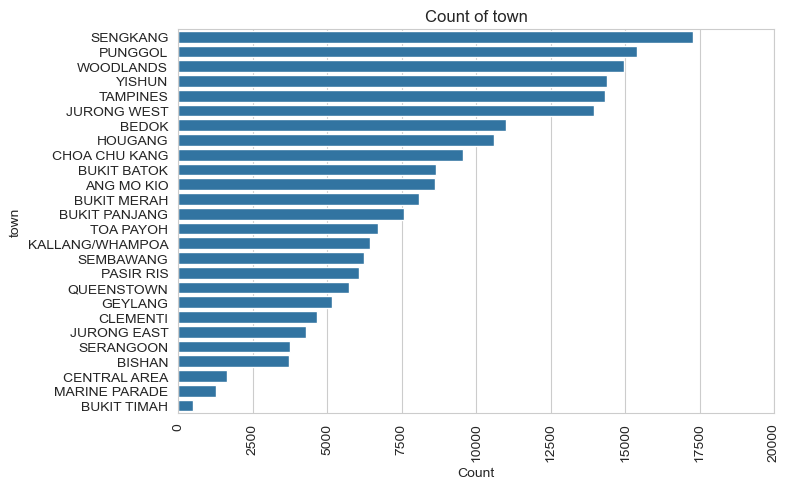

--------------------------------
Rare threshold of 1.0%
                 value_count   percent  is_rare
town                                           
SENGKANG               17295  0.082052    False
PUNGGOL                15399  0.073057    False
WOODLANDS              14959  0.070969    False
YISHUN                 14395  0.068293    False
TAMPINES               14339  0.068028    False
JURONG WEST            13949  0.066177    False
BEDOK                  11008  0.052225    False
HOUGANG                10619  0.050379    False
CHOA CHU KANG           9566  0.045383    False
BUKIT BATOK             8663  0.041099    False
ANG MO KIO              8629  0.040938    False
BUKIT MERAH             8070  0.038286    False
BUKIT PANJANG           7580  0.035961    False
TOA PAYOH               6710  0.031834    False
KALLANG/WHAMPOA         6444  0.030572    False
SEMBAWANG               6252  0.029661    False
PASIR RIS               6087  0.028878    False
QUEENSTOWN              5749  0.

In [53]:
plot_categorical_column(df,'town')

**The feature `town` has 26 unique values. Since town is a nominal categorical variable and not ordinal, we will use one-hot encoding. The top 3 towns with the highest transaction turnover are SENGKANG, PUNGGOL, and WOODLANDS.**

**The towns CENTRAL AREA, MARINE PARADE, and BUKIT TIMAH have transaction counts that are less than 1% of the total transactions. Due to their rare occurrence, these categories might potentially impact predictive power, particularly for models sensitive to sparsity. One option to address this could be to group these three towns into a single "RARE" or "PREMIUM" category to potentially improve predictive capabilities.**

**However, grouping them may distort valuable information if there are changes to the trends or characteristics of these specific towns in future data. Therefore, we have decided to keep all towns as separate categories with one-hot encoding. We will be using tree-based models, which are robust to rare categories and high-cardinality features, to handle these less frequent occurrences effectively.**

#### Categorical Feature Column: Flat type

flat_type
--------------------------------
flat_type describe:
count     210782
unique         7
top       4 ROOM
freq       89112
Name: flat_type, dtype: object
--------------------------------


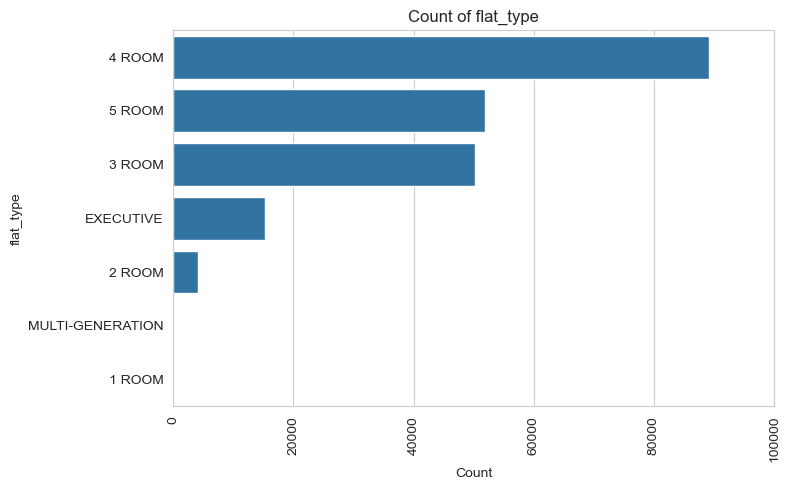

--------------------------------
Rare threshold of 1.0%
                  value_count   percent  is_rare
flat_type                                       
4 ROOM                  89112  0.422769    False
5 ROOM                  51888  0.246169    False
3 ROOM                  50179  0.238061    False
EXECUTIVE               15299  0.072582    False
2 ROOM                   4143  0.019655    False
MULTI-GENERATION           84  0.000399     True
1 ROOM                     77  0.000365     True


In [54]:
plot_categorical_column(df, 'flat_type')

**Analysis of `flat_type` Feature:**

**The `flat_type` feature contains 7 unique categories. The most popular resale flat types are 4 ROOM (42.27%), followed by 5 ROOM (24.63%) and 3 ROOM (23.80%), collectively accounting for the vast majority of transactions.**

**Given the inherent ordinality of flat types (e.g., 1-room, 2-room, 3-room, 4-room, 5-room, Executive, Multi-Generation typically representing increasing size), we may consider ordinal encoding for models that can leverage this ordered relationship, such as linear models.** 

**However, we discovered that there are exceptions and outliers in 3-room flat with floor area more than 200sqm. This is unusual. We found that during the 1960s, there are terrace flat model which are categorized as 3-room flat, these flats has very high floor area that are more than 200sqm. HDB has stop building such flat. Given the new information, we think that it is best to use one-hot encoding as it avoids assumptions about the linearity of the ordinal relationship.** 

**The MULTI-GENERATION and 1 ROOM flat types each represent less than 0.04% of total transactions, falling below our 1.0% rare threshold. We have decided not to group these sparse categories into an 'Other' type. This is because despite their rare occurrence, these specific flat types likely contain valuable and distinct information (e.g., 1-room flats typically being the smallest/lowest priced, and multi-generation flats being unique, large units). To effectively handle these rare occurrences and capture their potentially unique impact without distortion, we will rely on robust model-level smoothing provided by ensemble models (e.g., Random Forest, Gradient Boosting), which are well-suited for sparse categorical features.**

#### Categorical Feature Column: Storey Range

storey_range
--------------------------------
storey_range describe:
count       210782
unique          17
top       04 TO 06
freq         48405
Name: storey_range, dtype: object
--------------------------------


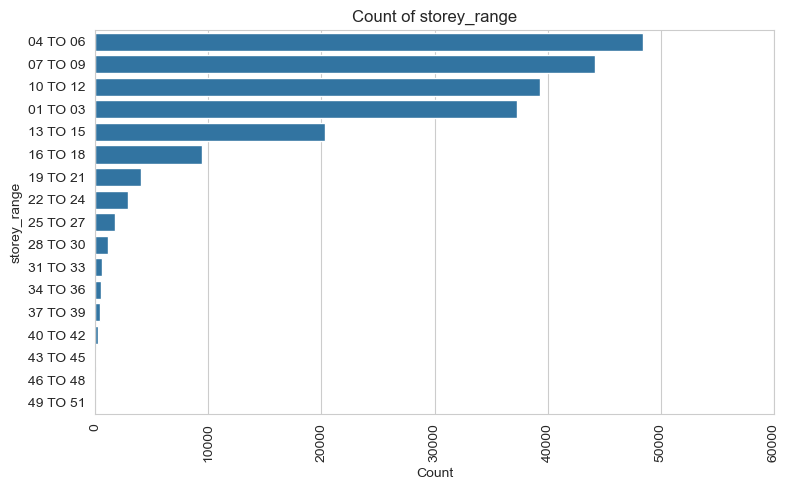

--------------------------------
Rare threshold of 1.0%
              value_count   percent  is_rare
storey_range                                
04 TO 06            48405  0.229645    False
07 TO 09            44184  0.209619    False
10 TO 12            39315  0.186520    False
01 TO 03            37258  0.176761    False
13 TO 15            20290  0.096261    False
16 TO 18             9474  0.044947    False
19 TO 21             4082  0.019366    False
22 TO 24             2862  0.013578    False
25 TO 27             1773  0.008412     True
28 TO 30             1144  0.005427     True
31 TO 33              626  0.002970     True
34 TO 36              558  0.002647     True
37 TO 39              463  0.002197     True
40 TO 42              220  0.001044     True
43 TO 45               65  0.000308     True
46 TO 48               45  0.000213     True
49 TO 51               18  0.000085     True


In [55]:
plot_categorical_column(df, 'storey_range')

**Given its ordinarity nature, we will convert the categories from string to numerical number. We do that by extracting the numerical number and take the average. For example, if storey range is from 7th floor to 9th floor. We will take the middle floor, 8th floor as the indicator.**

In [56]:
def convert_storey_range(storey_range):
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [57]:
def test_convert_storey_range():
    """Test cases for convert_storey_range function"""
    
    # Basic test case from the example
    assert convert_storey_range('07 TO 09') == 8.0
    
    # Test with single digits
    assert convert_storey_range('1 TO 3') == 2.0
    assert convert_storey_range('5 TO 7') == 6.0
    
    # Test with same storey (no range)
    assert convert_storey_range('05 TO 05') == 5.0
    assert convert_storey_range('10 TO 10') == 10.0
    
    # Test with larger ranges
    assert convert_storey_range('01 TO 05') == 3.0
    assert convert_storey_range('10 TO 20') == 15.0
    
    # Test with double digits
    assert convert_storey_range('12 TO 16') == 14.0
    assert convert_storey_range('25 TO 35') == 30.0
    
    # Test with leading zeros
    assert convert_storey_range('01 TO 03') == 2.0
    assert convert_storey_range('08 TO 12') == 10.0
    
    # Test odd ranges (result should be .5)
    assert convert_storey_range('1 TO 2') == 1.5
    assert convert_storey_range('10 TO 11') == 10.5
    
    # Test with higher floors
    assert convert_storey_range('50 TO 60') == 55.0
    assert convert_storey_range('99 TO 101') == 100.0

    print("All test cases passed!")


test_convert_storey_range()

All test cases passed!


In [58]:

def test_convert_storey_range_edge_cases():
    """Test edge cases and potential error scenarios"""
    
    # Test ground floor scenarios
    assert convert_storey_range('0 TO 2') == 1.0
    assert convert_storey_range('00 TO 01') == 0.5
    
    # Test with mixed formatting
    assert convert_storey_range('5 TO 15') == 10.0
    assert convert_storey_range('02 TO 8') == 5.0

    print("All edge case tests passed!")

test_convert_storey_range_edge_cases()

All edge case tests passed!


In [59]:

import pytest
def test_convert_storey_range_errors():
    """Test error handling scenarios"""
    
    # Test invalid format (should raise ValueError)
    with pytest.raises(ValueError):
        convert_storey_range('invalid format')
    
    with pytest.raises(ValueError):
        convert_storey_range('5-7')  # Wrong separator
    
    with pytest.raises(ValueError):
        convert_storey_range('5 TO')  # Missing high value
    
    with pytest.raises(ValueError):
        convert_storey_range('TO 7')  # Missing low value
    
    # Test non-numeric values
    with pytest.raises(ValueError):
        convert_storey_range('A TO B')
    
    with pytest.raises(ValueError):
        convert_storey_range('1 TO B')

    print("All error handling tests passed!")

test_convert_storey_range_errors()

All error handling tests passed!


In [60]:

# Alternative test format using unittest if you prefer
import unittest

class TestConvertStoreyRange(unittest.TestCase):
    
    def test_basic_functionality(self):
        """Test basic functionality"""
        self.assertEqual(convert_storey_range('07 TO 09'), 8.0)
        self.assertEqual(convert_storey_range('1 TO 3'), 2.0)
        self.assertEqual(convert_storey_range('10 TO 20'), 15.0)
        print("Basic functionality test passed!")
    
    def test_same_storey(self):
        """Test when low and high are the same"""
        self.assertEqual(convert_storey_range('05 TO 05'), 5.0)
        self.assertEqual(convert_storey_range('10 TO 10'), 10.0)
        print("Same storey test passed!")
    
    def test_decimal_results(self):
        """Test cases that result in decimal values"""
        self.assertEqual(convert_storey_range('1 TO 2'), 1.5)
        self.assertEqual(convert_storey_range('10 TO 11'), 10.5)
        print("Decimal results test passed!")
    
    def test_invalid_input(self):
        """Test invalid input handling"""
        with self.assertRaises(ValueError):
            convert_storey_range('invalid')
        with self.assertRaises(ValueError):
            convert_storey_range('A TO B')
        print("Invalid input test passed!")


unit_test = TestConvertStoreyRange()
unit_test.test_basic_functionality()
unit_test.test_same_storey()
unit_test.test_decimal_results()
unit_test.test_invalid_input()

Basic functionality test passed!
Same storey test passed!
Decimal results test passed!
Invalid input test passed!


In [61]:
df.storey_range = df.storey_range.apply(convert_storey_range)
df.storey_range

0         11.0
1          2.0
2          2.0
3          5.0
4          2.0
          ... 
211081     5.0
211082     5.0
211083     5.0
211084     5.0
211085     2.0
Name: storey_range, Length: 210782, dtype: float64

In [62]:
df.storey_range

0         11.0
1          2.0
2          2.0
3          5.0
4          2.0
          ... 
211081     5.0
211082     5.0
211083     5.0
211084     5.0
211085     2.0
Name: storey_range, Length: 210782, dtype: float64

In [63]:
df.storey_range.describe()

count    210782.000000
mean          8.759700
std           5.935456
min           2.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          50.000000
Name: storey_range, dtype: float64

**This feature column has been convert as numerical columns as it contains ordinality and we can take the average as the reference indicator.**

#### Categorical Feature Column: Flat Model

flat_model
--------------------------------
flat_model describe:
count      210782
unique         21
top       Model A
freq        74858
Name: flat_model, dtype: object
--------------------------------


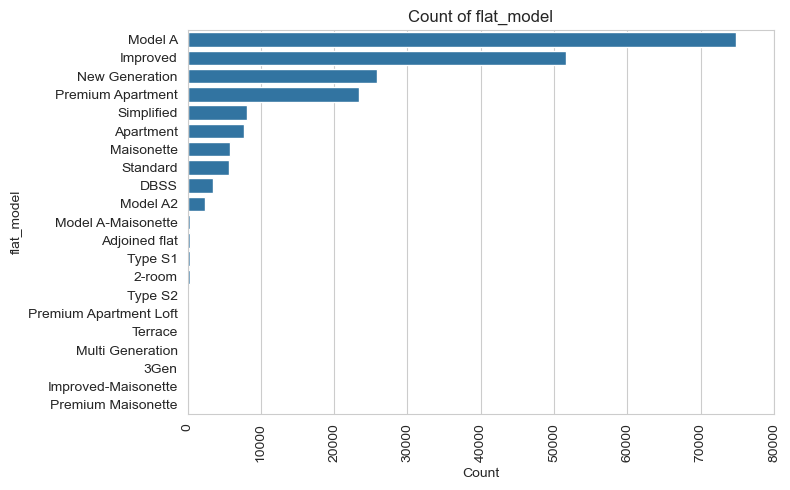

--------------------------------
Rare threshold of 1.0%
                        value_count   percent  is_rare
flat_model                                            
Model A                       74858  0.355144    False
Improved                      51605  0.244826    False
New Generation                25902  0.122885    False
Premium Apartment             23373  0.110887    False
Simplified                     8074  0.038305    False
Apartment                      7676  0.036417    False
Maisonette                     5859  0.027796    False
Standard                       5665  0.026876    False
DBSS                           3409  0.016173    False
Model A2                       2393  0.011353    False
Model A-Maisonette              373  0.001770     True
Adjoined flat                   360  0.001708     True
Type S1                         343  0.001627     True
2-room                          299  0.001419     True
Type S2                         178  0.000844     True
Premium A

In [64]:
plot_categorical_column(df, 'flat_model')

**There are more sparse categories, however, each categories contains its unique information which maybe helpful in differentiating between different type of flats with different model and its different pricing. We will use one-hot encoding since there is no ordinarity in this feature.**

**Examples:**

- Maisonette and Premium Maisonette are duplex units.
- DBSS (Design, Build and Sell Scheme) flats were built by private developers and often have condo-like features.
- Terrace flats are the specific, large 3-room flats build in the 1960s.
- Multi Generation and 3Gen are specific multi-generational living units.

**These are not just "rare" in frequency but "rare" in their type and market position. Grouping them into an "Other" category would likely lead to a significant loss of valuable information.**

**We will be using tree-based ensemble model to handle the sparsity of the features.**

#### Categorical Feature Column: Remaining Lease

remaining_lease
--------------------------------
remaining_lease describe:
count                 210782
unique                   690
top       94 years 10 months
freq                    1861
Name: remaining_lease, dtype: object
--------------------------------


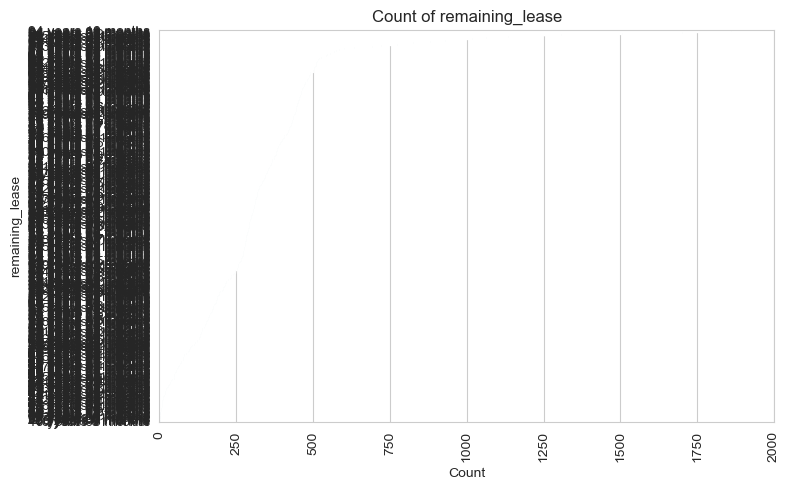

--------------------------------
Rare threshold of 1.0%
                    value_count   percent  is_rare
remaining_lease                                   
94 years 10 months         1861  0.008829     True
94 years 09 months         1835  0.008706     True
94 years 11 months         1809  0.008582     True
94 years 08 months         1700  0.008065     True
94 years 07 months         1603  0.007605     True
...                         ...       ...      ...
97 years 07 months            1  0.000005     True
95 years 0 months             1  0.000005     True
66 years 0 months             1  0.000005     True
40 years 01 month             1  0.000005     True
40 years 05 months            1  0.000005     True

[690 rows x 3 columns]


In [65]:
plot_categorical_column(df, 'remaining_lease')

**With 690 categories, we consider this feature has high cardinality. Thus we will convert this feature from string to numerical column. We will convert the remaining lease into a new column `remaining_lease_by_month`. We will convert the years into months and add to the remaining months. For example, `94 years 10 months` will be converted to 1138 months.**

In [66]:
def convert_lease_to_month(lease):
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        t_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        t_month = (year * 12)
    else:
        year = int(str_list[0])
        t_month = (year * 12)        
    return t_month

In [67]:

def test_convert_lease_to_month_simple():
    """Simple test cases for convert_lease_to_month function"""
    
    # Test years and months format
    assert convert_lease_to_month('5 years 6 months') == 66  # 5*12 + 6 = 66
    assert convert_lease_to_month('2 years 3 months') == 27  # 2*12 + 3 = 27
    assert convert_lease_to_month('1 years 0 months') == 12  # 1*12 + 0 = 12
    
    # Test years only format
    assert convert_lease_to_month('10 years') == 120  # 10*12 = 120
    assert convert_lease_to_month('5 years') == 60    # 5*12 = 60
    assert convert_lease_to_month('1 years') == 12    # 1*12 = 12
    
    # Test with singular 'month'
    assert convert_lease_to_month('3 years 1 month') == 37   # 3*12 + 1 = 37
    assert convert_lease_to_month('0 years 1 month') == 1    # 0*12 + 1 = 1
    
    # Test just numbers (should default to years)
    assert convert_lease_to_month('5') == 60    # 5*12 = 60
    assert convert_lease_to_month('2') == 24    # 2*12 = 24
    print("All simple test cases passed!")

test_convert_lease_to_month_simple()

All simple test cases passed!


In [68]:

def test_convert_lease_to_month_variations():
    """Test various input formats"""
    
    # Test different plural/singular combinations
    assert convert_lease_to_month('1 year 1 month') == 13    # Should work if 'year' -> 'years'
    assert convert_lease_to_month('10 years 11 months') == 131  # 10*12 + 11 = 131
    
    # Test zero cases
    assert convert_lease_to_month('0 years 6 months') == 6   # 0*12 + 6 = 6
    assert convert_lease_to_month('0 years') == 0      
    print("All variations test cases passed!")

test_convert_lease_to_month_variations()

All variations test cases passed!


In [69]:
df['remaining_lease_by_month'] = df.remaining_lease.apply(convert_lease_to_month)

In [70]:
df['remaining_lease_by_month'].describe()

count    210782.000000
mean        892.319121
std         169.953663
min         481.000000
25%         752.000000
50%         890.000000
75%        1064.000000
max        1173.000000
Name: remaining_lease_by_month, dtype: float64

**By converting this feature from string with year and months into numerical months, we can better manage this feature and this feature column also carry important information of the remaining live of a flat that may impacted the resale price.**

## Bivariate Analysis: Feature vs Target

In [71]:
# capture updated numerical and categorical columns
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns  

In [72]:
numerical_columns

Index(['storey_range', 'floor_area_sqm', 'lease_commence_date', 'resale_price',
       'remaining_lease_by_month'],
      dtype='object')

In [73]:
numerical_features = numerical_columns.drop('resale_price')
numerical_features

Index(['storey_range', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease_by_month'],
      dtype='object')

In [74]:
target = 'resale_price'

In [75]:
def plot_numerical_features_with_target(df: pd.DataFrame,
                                        numerical_column: str,
                                        target: str = "resale_price"):
    """
    Extended numeric-vs-target EDA:
    • scatter + LOWESS smooth
    • regplot with linear fit
    • Pearson & Spearman correlations
    • residual plot (checks homoskedasticity / curvature)
    • optional log-target & price-per-sqm transforms
    """

    # ---------- 0. header ----------
    print("="*80)
    print(f"Feature: {numerical_column}   ↔   Target: {target}")
    print("="*80)

    # ---------- 1. scatter + LOWESS ----------
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=df, x=numerical_column, y=target, alpha=0.25, ax=ax)

    # LOWESS curve (locally-weighted regression)
    lowess = sm.nonparametric.lowess
    lo = lowess(df[target], df[numerical_column], frac=0.3, return_sorted=True)
    ax.plot(lo[:, 0], lo[:, 1], lw=2, label="LOWESS")
    ax.set_title(f"{numerical_column} vs {target} with LOWESS")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2. regplot (linear fit) ----------
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.regplot(data=df, x=numerical_column, y=target,
                scatter_kws={"alpha": 0.15},
                line_kws={"lw": 2}, ax=ax)
    ax.set_title(f"Linear fit of {target} on {numerical_column}")
    plt.tight_layout()
    plt.show()

    # ---------- 3. Residual plot ----------
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.residplot(data=df, x=numerical_column, y=target,
                  lowess=True, scatter_kws={"alpha": 0.2}, ax=ax)
    ax.set_title(f"Residuals: {target} ~ {numerical_column}")
    plt.tight_layout()
    plt.show()

    # ---------- 4. Correlation metrics ----------
    pearson_r, pearson_p = st.pearsonr(df[numerical_column], df[target])
    spearman_r, spearman_p = st.spearmanr(df[numerical_column], df[target], nan_policy="omit")

    print(f"Pearson r = {pearson_r:.3f}  (p={pearson_p:.3g})")
    print(f"Spearman ρ = {spearman_r:.3f}  (p={spearman_p:.3g})")

    # ---------- 5. Simple transform checks ----------
    # A. Log-price
    if (df[target] > 0).all():
        df["_log_price"] = np.log(df[target])
        log_corr = df[[numerical_column, "_log_price"]].corr(method="pearson").iloc[0, 1]
        print(f"Pearson r vs log({target}) = {log_corr:.3f}")

    # B. Price per sqm if the column is floor area
    if numerical_column.lower().startswith("floor_area"):
        df["_price_psm"] = df[target] / df[numerical_column]
        ppsm_corr = df[["_price_psm", numerical_column]].corr(method="pearson").iloc[0, 1]
        print(f"Corr(floor_area, price_per_sqm) = {ppsm_corr:.3f}")

    print("")  # spacer


In [76]:
numerical_features

Index(['storey_range', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease_by_month'],
      dtype='object')

#### Numerical Feature Column: Storey Range with HDB Resale Price

Feature: storey_range   ↔   Target: resale_price


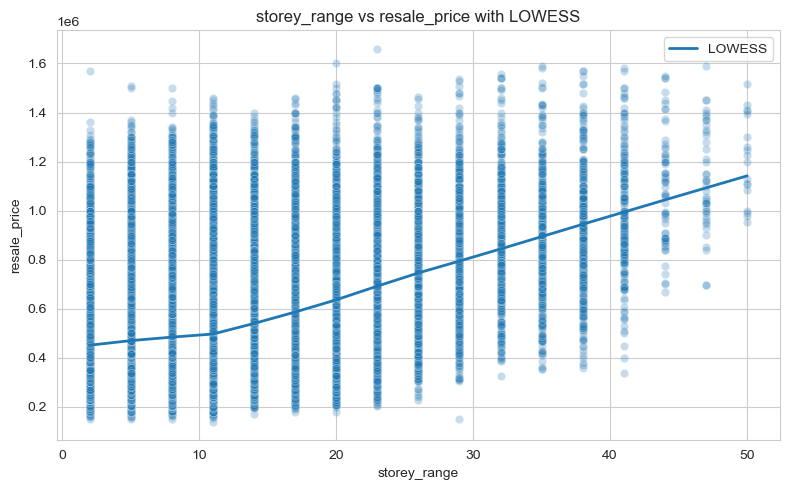

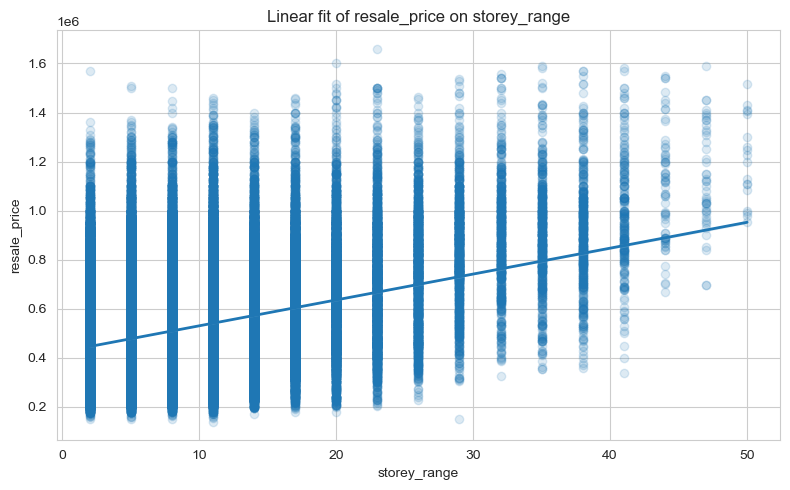

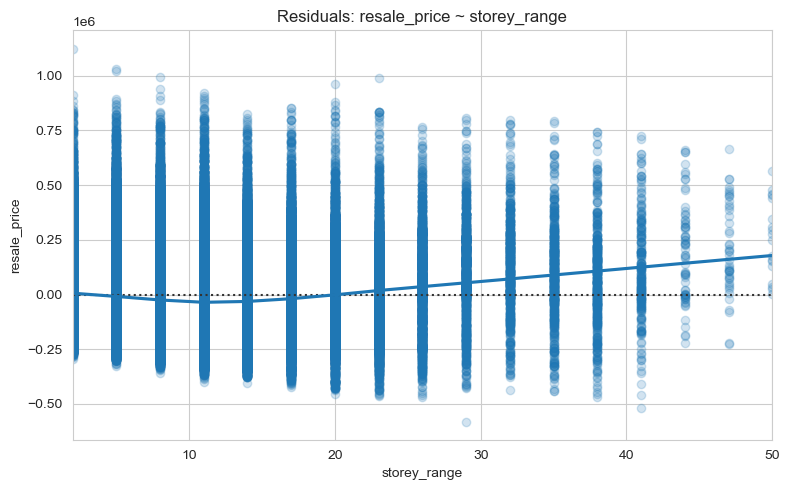

Pearson r = 0.343  (p=0)
Spearman ρ = 0.248  (p=0)
Pearson r vs log(resale_price) = 0.316



In [77]:
plot_numerical_features_with_target(df, 'storey_range')

In [78]:
df['storey_range'].corr(df['resale_price'])

np.float64(0.34252020902528435)

In [79]:
from scipy import stats
pearson_r,  p1 = stats.pearsonr(df['storey_range'], df['resale_price'])
spearman_r, p2 = stats.spearmanr(df['storey_range'], df['resale_price'])
print(f"Pearson r = {pearson_r:.3f}, p = {p1:.3g}")
print(f"Spearman ρ = {spearman_r:.3f}, p = {p2:.3g}")

Pearson r = 0.343, p = 0
Spearman ρ = 0.248, p = 0


In [80]:
from scipy import stats
import numpy as np

# Log-price to curb spread
log_price = np.log(df['resale_price'])

r_log, _ = stats.pearsonr(df['storey_range'], log_price)
rho_log,_ = stats.spearmanr(df['storey_range'], log_price)

print(f"Pearson r (log-price)   = {r_log:.3f}")
print(f"Spearman ρ (log-price)  = {rho_log:.3f}")

Pearson r (log-price)   = 0.316
Spearman ρ (log-price)  = 0.248


Text(0.5, 1.0, 'Price distribution per storey')

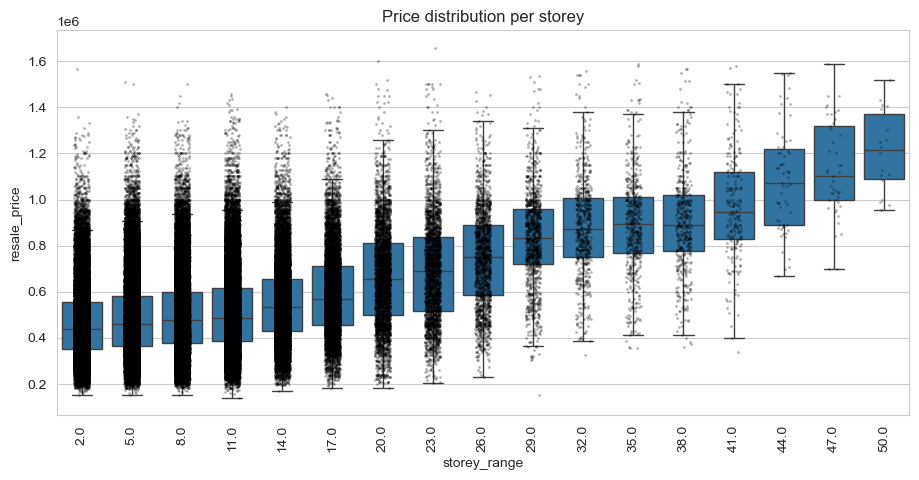

In [81]:
plt.figure(figsize=(11,5))
sns.boxplot(x='storey_range', y='resale_price', data=df, showfliers=False)
sns.stripplot(x='storey_range', y='resale_price', data=df,
              alpha=.3, jitter=.15, color='black', size=2)
plt.xticks(rotation=90); plt.title("Price distribution per storey")

<Axes: title={'center': 'IQR of price by floor'}, xlabel='storey_range'>

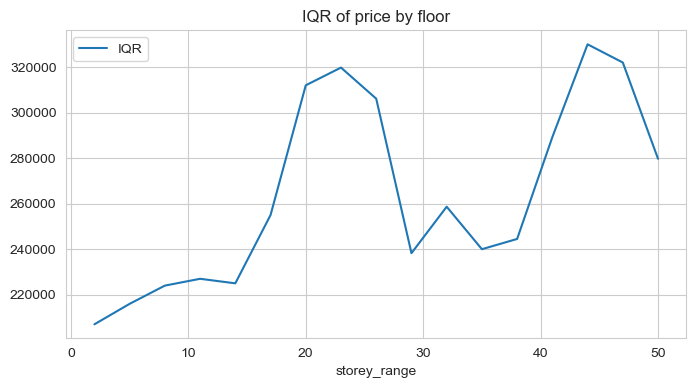

In [82]:
spread = (
    df.groupby('storey_range')['resale_price']
      .agg(median='median',
           IQR   =lambda s: s.quantile(0.75) - s.quantile(0.25),
           std   ='std',
           count ='size')
)
spread.plot(y='IQR', figsize=(8,4), title='IQR of price by floor')



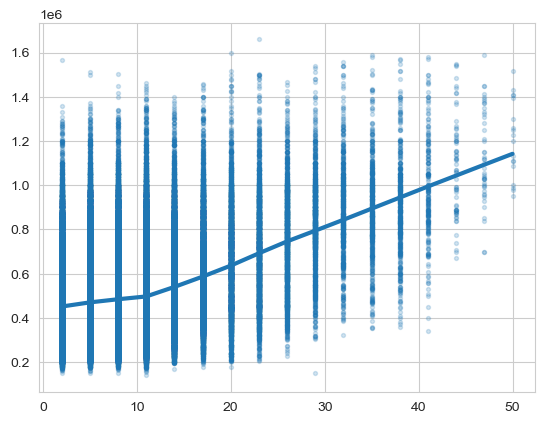

In [83]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
smoothed = lowess(df['resale_price'], df['storey_range'], frac=0.3)
plt.scatter(df['storey_range'], df['resale_price'], s=8, alpha=.2)
plt.plot(smoothed[:,0], smoothed[:,1], lw=3)

In [84]:
import numpy as np
X = np.vander(df['storey_range'], 3)     # quadratic
coef = np.linalg.lstsq(X, df['resale_price'], rcond=None)[0]
pred = X @ coef

<Axes: xlabel='storey_range', ylabel='resale_price'>

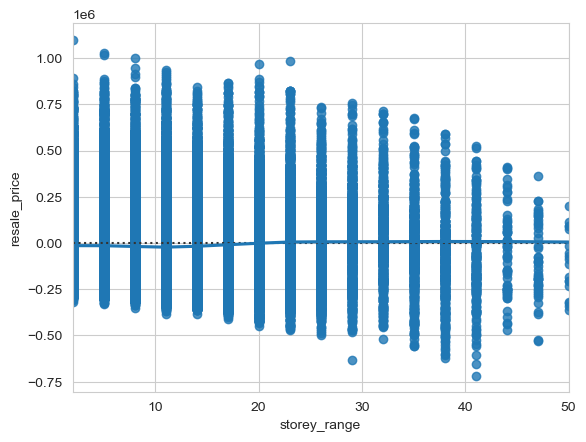

In [85]:
resid = df['resale_price'] - pred
sns.residplot(x=df['storey_range'], y=resid, lowess=True)

In [86]:
import pandas as pd, scipy.stats as st
df['floor_bin'] = pd.cut(df['storey_range'], [0,20,40,60],
                         labels=['low','mid','high'])
anova_F, anova_p = st.f_oneway(*(df.loc[df.floor_bin==b,'resale_price']
                                 for b in df.floor_bin.unique()))
print(f"ANOVA p-value = {anova_p:.4g}")


ANOVA p-value = 0


In [87]:
import statsmodels.api as sm
mod = sm.QuantReg(df['resale_price'], sm.add_constant(df['storey_range']))
for q in [0.1, 0.5, 0.9]:
    res = mod.fit(q=q)
    print(f"q={q}: slope = {res.params[1]:.0f}")

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_6042/2087880262.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"q={q}: slope = {res.params[1]:.0f}")


q=0.1: slope = 6333
q=0.5: slope = 11000
q=0.9: slope = 12857


**There is moderate collinearity between `storey_range` and `resale_price`.**

#### Numerical Feature Column: Floor Area (sqm) with HDB Resale Price

Feature: floor_area_sqm   ↔   Target: resale_price


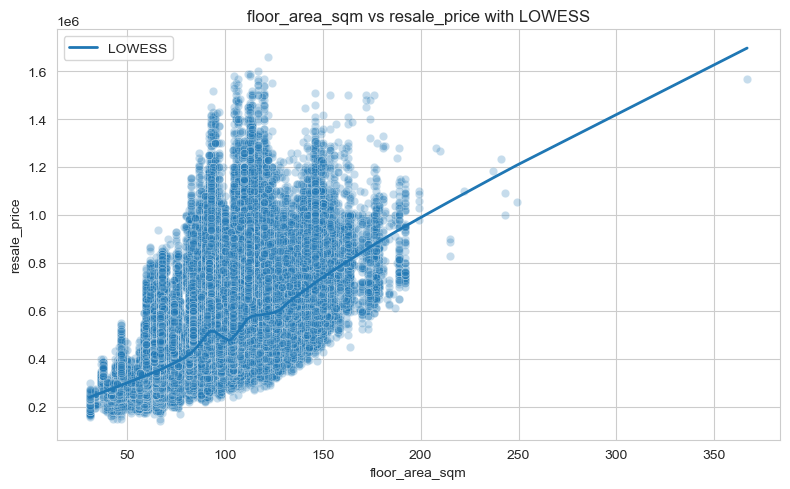

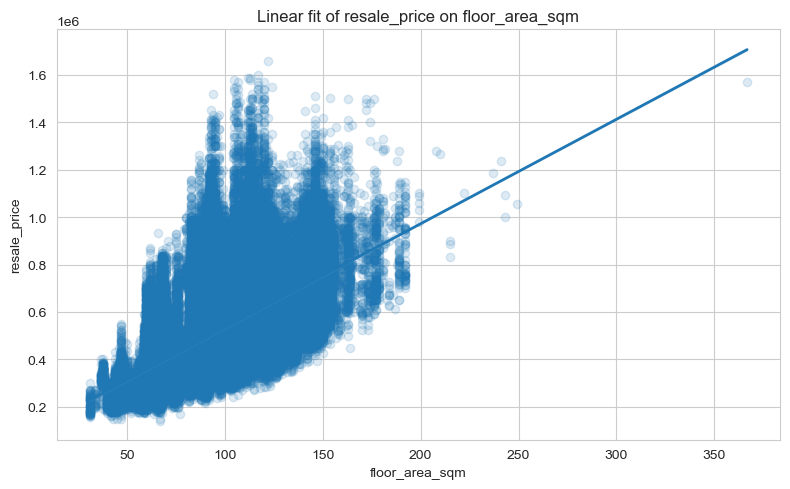

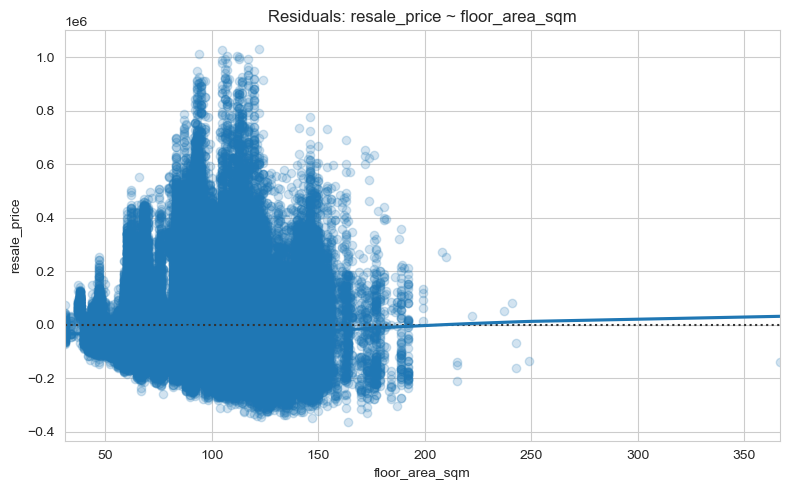

Pearson r = 0.579  (p=0)
Spearman ρ = 0.616  (p=0)
Pearson r vs log(resale_price) = 0.623
Corr(floor_area, price_per_sqm) = -0.145



In [88]:
plot_numerical_features_with_target(df, 'floor_area_sqm')

In [89]:
df['floor_area_sqm'].corr(df['resale_price'])

np.float64(0.579277366211653)

**There is high collinearity between `floor_area_sqm` and the `resale_price`.**

In [90]:

# Pearson & Spearman in one go
num_cols = df.select_dtypes('number').columns
corrs = df[num_cols].corr(method='spearman')['resale_price'].sort_values(ascending=False)
print(corrs.head(10))


resale_price                1.000000
_log_price                  1.000000
_price_psm                  0.648347
floor_area_sqm              0.616251
lease_commence_date         0.412372
remaining_lease_by_month    0.334200
storey_range                0.248156
Name: resale_price, dtype: float64


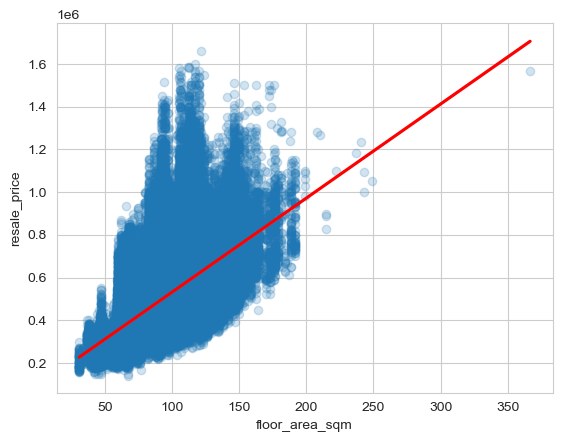

In [91]:

sns.regplot(x='floor_area_sqm', y='resale_price', data=df,
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.show()


/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_6042/1569623290.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('area_bin')['resale_price'].agg(['median','count'])


<Axes: xlabel='area_bin'>

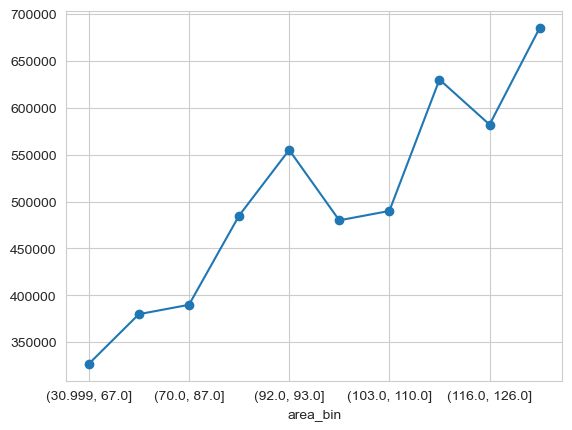

In [92]:

# Bin X into deciles and plot median target
df['area_bin'] = pd.qcut(df['floor_area_sqm'], 10, duplicates='drop')
bin_stats = df.groupby('area_bin')['resale_price'].agg(['median','count'])
bin_stats['median'].plot(marker='o')

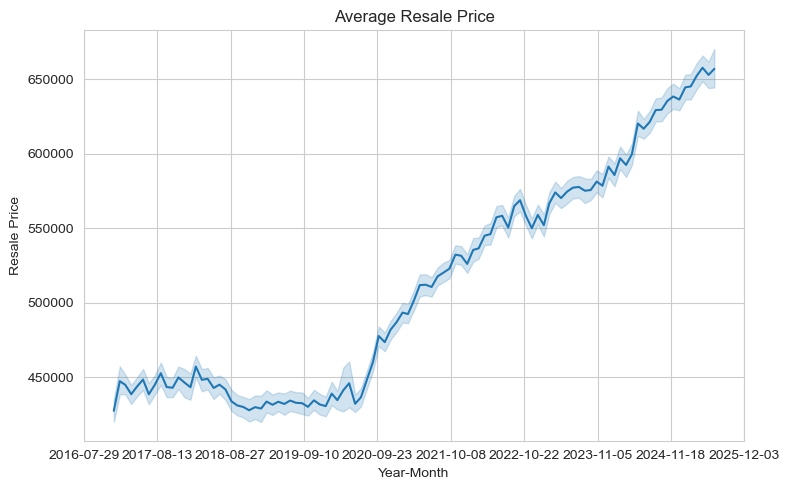

In [93]:
month_dt = pd.to_datetime(df['month'])
df_sorted = df.assign(month_dt=month_dt).sort_values('month_dt')

fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(data=df_sorted, x='month_dt', y='resale_price', estimator='mean')

ax.set_title('Average Resale Price')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Resale Price')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))

plt.tight_layout()
plt.show()

**Average resale price varies over the years. This could be due to different flat types and location. It will be more meaningful to explore the average price by flat type. floor area and location.**

### Cyclical Analysis of Resale Transaction

In [94]:
month_counts = df.month.value_counts().sort_index()
month_counts.head()

month
2017-01    1176
2017-02    1080
2017-03    1889
2017-04    1821
2017-05    1961
Name: count, dtype: int64

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_6042/1459698620.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


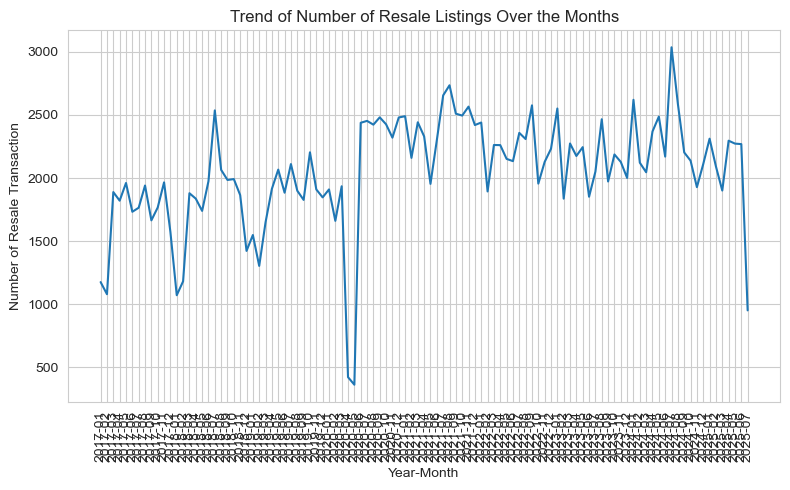

In [95]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(x=month_counts.index, y=month_counts.values, ax=ax)

ax.set_title('Trend of Number of Resale Listings Over the Months')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Number of Resale Transaction')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

**HDB resale is seasonal and the month of February has the lowers resale transaction.**

### Million Dollar HDB

In [96]:
# Extract resale price that is more than 1 million excluding 2016
df_high_price = df[df['resale_price'] > 1000000].copy()

# add year column 
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price = df_high_price[df_high_price['year'] != 2019]

# print the number of flats with resale price above 1 million
print(f"Number of flats with resale price above 1 million: {len(df_high_price)}")

# calculate the percentage of high resale price flats against total flats
high_price_percentage = (len(df_high_price) / len(df)) * 100
print(f"Percentage of flats with resale price above 1 million: {high_price_percentage:.2f}%") 

Number of flats with resale price above 1 million: 2888
Percentage of flats with resale price above 1 million: 1.37%


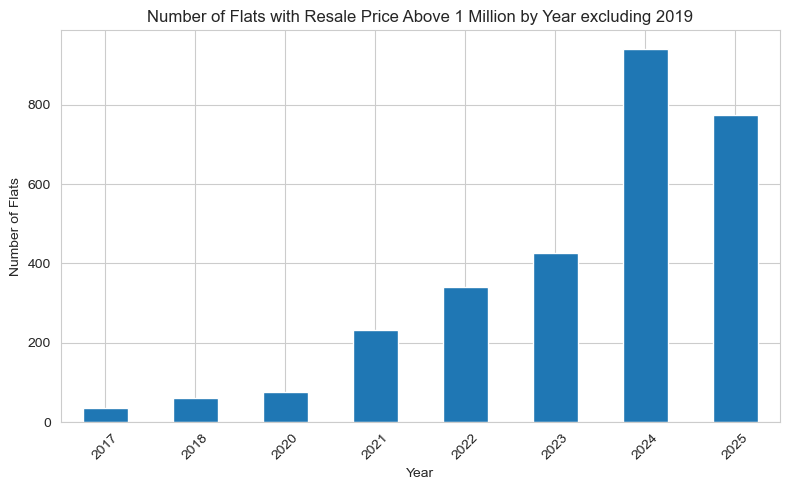

In [97]:
# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year excluding 2019')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Flat Model Name 

**There are also missing values in flat model name.**

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210782 entries, 0 to 211085
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   month                     210782 non-null  object  
 1   town                      210782 non-null  object  
 2   flat_type                 210782 non-null  object  
 3   storey_range              210782 non-null  float64 
 4   floor_area_sqm            210782 non-null  float64 
 5   flat_model                210782 non-null  object  
 6   lease_commence_date       210782 non-null  int64   
 7   remaining_lease           210782 non-null  object  
 8   resale_price              210782 non-null  float64 
 9   remaining_lease_by_month  210782 non-null  int64   
 10  _log_price                210782 non-null  float64 
 11  floor_bin                 210782 non-null  category
 12  _price_psm                210782 non-null  float64 
 13  area_bin                  210782 n

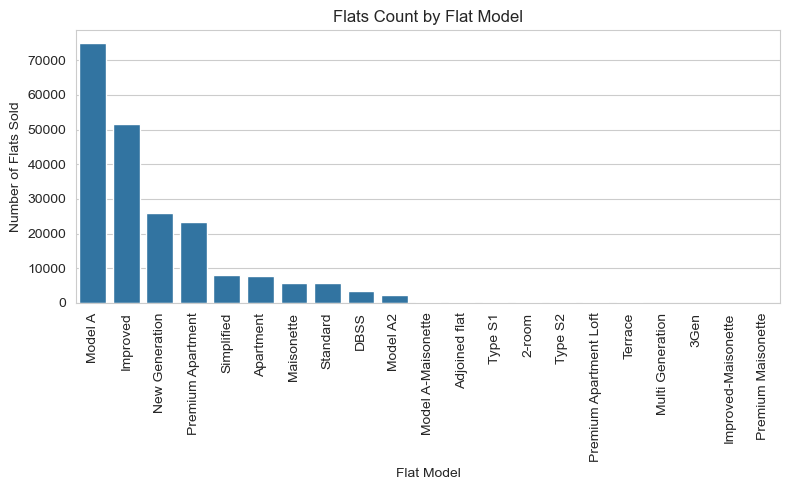

In [99]:
fig, ax = plt.subplots(figsize=(8,5))  
sns.set_style("whitegrid")

sorted_flat_model_name = df.flat_model.value_counts()
sorted_flat_model_index = sorted_flat_model_name.index
sns.countplot(data=df, x='flat_model', order=sorted_flat_model_index, ax=ax)

ax.set_title('Flats Count by Flat Model')
ax.set_xlabel('Flat Model')
ax.set_ylabel('Number of Flats Sold')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 90)


plt.tight_layout()
plt.show()

**Top 3 model with the most transaction is Model A, Improved and New Generation.**

### Flat Type and Resale Price

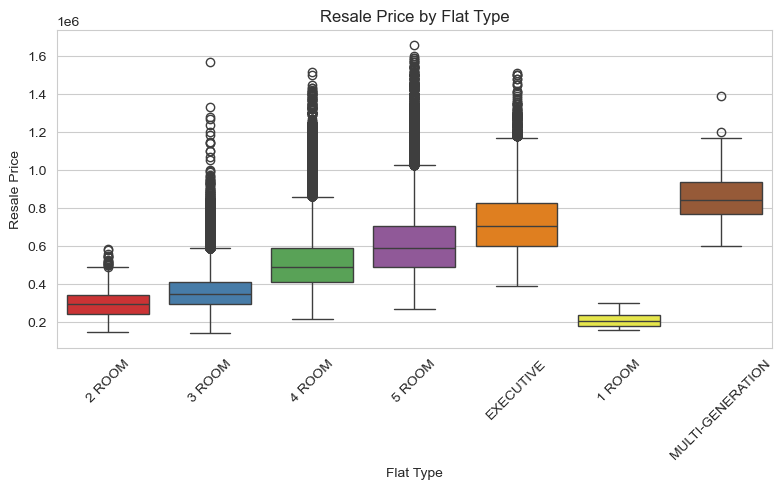

In [100]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='flat_type', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Resale Price by Flat Type')
ax.set_xlabel('Flat Type')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

**There are many outliers for '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', and 'EXECUTIVE' flats. Outliers likely happen maybe due to locations or renovation status.**

### Flat Type and Floor Area

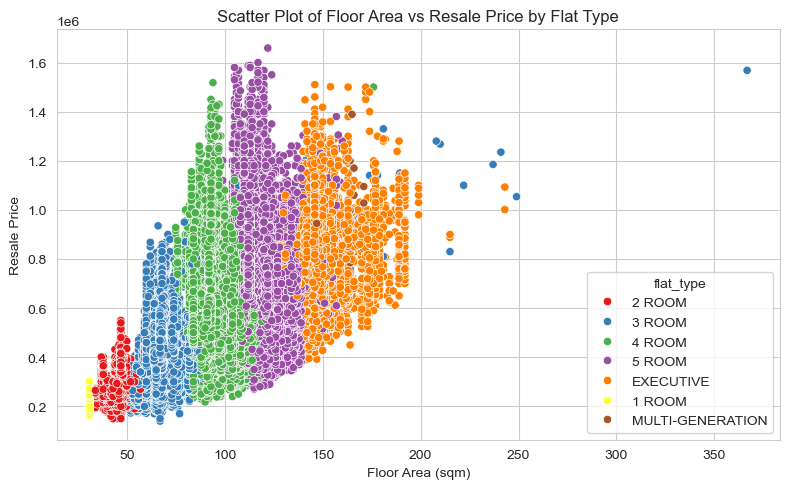

In [101]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Scatter Plot of Floor Area vs Resale Price by Flat Type')
ax.set_xlabel('Floor Area (sqm)')
ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

**Generally, the increase in floor area result in increase in resale price.**
  
**There are 3 ROOM flats that has a very high selling price and the floor area is also quite high. We need to investigate further.**

In [102]:
outliers_3_room = df[(df['flat_type'] == '3 ROOM') & (df['floor_area_sqm'] > 150) & (df['resale_price'] > 800000)]
outliers_3_room

month             town flat_type  storey_range  floor_area_sqm  \
7000    2017-05  KALLANG/WHAMPOA    3 ROOM           2.0           181.0   
8868    2017-06  KALLANG/WHAMPOA    3 ROOM           2.0           215.0   
19693   2017-12  KALLANG/WHAMPOA    3 ROOM           2.0           249.0   
27292   2018-05  KALLANG/WHAMPOA    3 ROOM           2.0           185.0   
29231   2018-06  KALLANG/WHAMPOA    3 ROOM           2.0           174.0   
35797   2018-09  KALLANG/WHAMPOA    3 ROOM           2.0           237.0   
53491   2019-07  KALLANG/WHAMPOA    3 ROOM           2.0           169.0   
79015   2020-09  KALLANG/WHAMPOA    3 ROOM           2.0           170.0   
95808   2021-04  KALLANG/WHAMPOA    3 ROOM           2.0           222.0   
95809   2021-04  KALLANG/WHAMPOA    3 ROOM           2.0           178.0   
100088  2021-06  KALLANG/WHAMPOA    3 ROOM           2.0           210.0   
102579  2021-07  KALLANG/WHAMPOA    3 ROOM           2.0           174.0   
107851  2021-09  KALLANG/WHAMPOA    3 ROOM           2.0           241.0   
155389  2023-01  KALLANG/WHAMPOA    3 ROOM           2.0           155.0   
181463  2024-07  KALLANG/WHAMPOA    3 ROOM           2.0           366.7   
181636  2024-08  KALLANG/WHAMPOA    3 ROOM           2.0           181.0   
182433  2024-05  KALLANG/WHAMPOA    3 ROOM           2.0           189.4   
182469  2024-02  KALLANG/WHAMPOA    3 ROOM           2.0           208.0   

       flat_model  lease_commence_date     remaining_lease  resale_price  \
7000      Terrace                 1972  54 years 02 months      810000.0   
8868      Terrace                 1972   54 years 01 month      830000.0   
19693     Terrace                 1972  53 years 07 months     1053888.0   
27292     Terrace                 1972  53 years 02 months      968000.0   
29231     Terrace                 1972  53 years 02 months      950000.0   
35797     Terrace                 1972  52 years 10 months     1185000.0   
53491     Terrace                 1972  52 years 03 months      975000.0   
79015     Terrace                 1972  50 years 10 months     1000000.0   
95808     Terrace                 1972  50 years 03 months     1100000.0   
95809     Terrace                 1972  50 years 04 months     1140000.0   
100088    Terrace                 1972   50 years 01 month     1268000.0   
102579    Terrace                 1972   50 years 01 month     1140000.0   
107851    Terrace                 1972  49 years 10 months     1235000.0   
155389    Terrace                 1972  48 years 07 months     1068000.0   
181463    Terrace                 1972            47 years     1568000.0   
181636    Terrace                 1972            47 years     1330000.0   
182433    Terrace                 1972  47 years 03 months     1150000.0   
182469    Terrace                 1972  47 years 06 months     1280000.0   

        remaining_lease_by_month  _log_price floor_bin   _price_psm  \
7000                         650   13.604790       low  4475.138122   
8868                         649   13.629181       low  3860.465116   
19693                        643   13.867997       low  4232.481928   
27292                        638   13.782987       low  5232.432432   
29231                        638   13.764217       low  5459.770115   
35797                        634   13.985253       low  5000.000000   
53491                        627   13.790193       low  5769.230769   
79015                        610   13.815511       low  5882.352941   
95808                        603   13.910821       low  4954.954955   
95809                        604   13.946539       low  6404.494382   
100088                       601   14.052951       low  6038.095238   
102579                       601   13.946539       low  6551.724138   
107851                       598   14.026582       low  5124.481328   
155389                       583   13.881298       low  6890.322581   
181463                       564   14.265311       low 

**The outliers are 3 ROOM flats that are built in 1972 where they have floor area of 180 sqm and above. Therefore, flat type is not good enough to differentiate the resale price. Flat model also plays an important differentiator.**

In [103]:
terrace_3_room = df[(df['flat_type'] == '3 ROOM') & (df['flat_model'] == "Terrace")]
terrace_3_room.describe()

storey_range  floor_area_sqm  lease_commence_date  resale_price  \
count         104.0      104.000000           104.000000  1.040000e+02   
mean            2.0      114.643269          1971.461538  8.776762e+05   
std             0.0       48.178158             1.371861  1.596752e+05   
min             2.0       78.000000          1968.000000  6.350000e+05   
25%             2.0       87.000000          1972.000000  7.750000e+05   
50%             2.0       94.500000          1972.000000  8.475000e+05   
75%             2.0      116.500000          1972.000000  9.300000e+05   
max             2.0      366.700000          1972.000000  1.568000e+06   

       remaining_lease_by_month  _log_price    _price_psm  
count                104.000000  104.000000    104.000000  
mean                 598.875000   13.670472   8222.175304  
std                   31.606712    0.167163   1698.051483  
min                  507.000000   13.361380   3860.465116  
25%                  572.250000   13.560618   7101.574501  
50%                  602.000000   13.650042   8473.792076  
75%                  626.000000   13.742940   9513.563495  
max                  652.000000   14.265311  11964.735516

- **Terrace was built between 1968 to 1972.**
- **Both floor area and resale price and very wide range.**
- **sqm range from 78 sqm to 280 sqm.**

Checking other similar situation.

In [104]:
df[['flat_type', 'flat_model', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flat_model']).mean()

floor_area_sqm  resale_price
flat_type        flat_model                                          
1 ROOM           Improved                     31.000000  2.098462e+05
2 ROOM           2-room                       45.117057  3.504695e+05
                 DBSS                         50.000000  3.675000e+05
                 Improved                     45.322404  2.511844e+05
                 Model A                      45.934070  3.082620e+05
                 Premium Apartment            52.514286  2.755111e+05
                 Standard                     45.102524  2.467825e+05
3 ROOM           DBSS                         65.163136  5.288459e+05
                 Improved                     65.347833  3.297278e+05
                 Model A                      70.146013  4.208843e+05
                 New Generation               70.027608  3.405962e+05
                 Premium Apartment            67.544487  4.749122e+05
                 Simplified                   64.312413  3.431274e+05
                 Standard                     60.812716  3.142748e+05
                 Terrace                     114.643269  8.776762e+05
4 ROOM           Adjoined flat               119.250000  6.440000e+05
                 DBSS                         88.881174  7.362184e+05
                 Improved                     85.320837  4.612547e+05
                 Model A                      97.486174  5.373194e+05
                 Model A2                     89.353949  4.136227e+05
                 New Generation               93.132364  4.467788e+05
                 Premium Apartment            94.182145  5.411453e+05
                 Premium Apartment Loft       97.876404  9.642281e+05
                 Simplified                   84.497721  4.198451e+05
                 Standard                     77.104167  4.389245e+05
                 Terrace                     121.100000  9.331429e+05
                 Type S1                      94.288630  1.051640e+06
5 ROOM           3Gen                        120.316667  7.427624e+05
                 Adjoined flat               135.357843  7.173545e+05
                 DBSS                        111.647594  9.184355e+05
                 Improved                    117.303855  6.014918e+05
                 Improved-Maisonette         136.333333  7.528851e+05
                 Model A                     134.396571  6.269473e+05
                 Model A-Maisonette          140.831099  7.849140e+05
                 Premium Apartment           113.646027  5.853435e+05
                 Premium Apartment Loft      140.960000  1.086377e+06
                 Standard                    118.835402  6.474265e+05
                 Type S2                     106.106742  1.150296e+06
EXECUTIVE        Adjoined flat               160.935484  8.504285e+05
                 Apartment                   144.428218  7.056359e+05
                 Maisonette                  148.005974  7.710544e+05
                 Premium Apartment           133.677956  6.188907e+05
                 Premium Maisonette          159.875000  8.164375e+05
MULTI-GENERATION Multi Generation            161.190476  8.567360e+05

**Besides 3 ROOM flat, other flat type also contains Terrace model. To get a more accurate prediction, flat type and flat model must be used together.**

### Million Dollar HDB

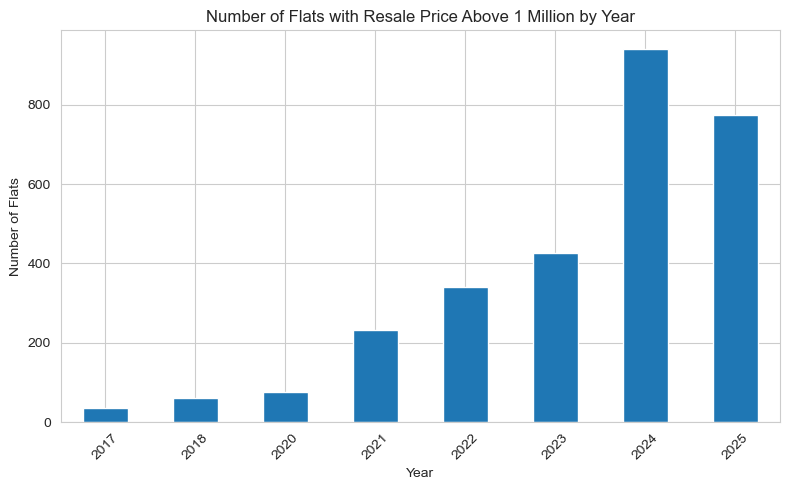

In [105]:

# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Resale Price By Town, Type and Model Analysis

In [106]:
town_breakdown = df[['town', 'floor_area_sqm', 'resale_price']].groupby(['town'])
town_breakdown[['floor_area_sqm']].describe()

floor_area_sqm                                             \
                         count        mean        std   min    25%    50%   
town                                                                        
ANG MO KIO              8629.0   85.125159  20.684202  44.0   68.0   82.0   
BEDOK                  11008.0   89.906432  24.467758  44.0   68.0   88.0   
BISHAN                  3711.0  107.619240  24.296512  63.0   88.0  105.0   
BUKIT BATOK             8663.0   94.151910  25.078179  37.0   73.0   93.0   
BUKIT MERAH             8070.0   87.072862  22.424584  31.0   67.0   90.0   
BUKIT PANJANG           7580.0  102.141425  20.735157  46.0   92.0  103.0   
BUKIT TIMAH              516.0  109.302326  26.120365  63.0   91.0  104.0   
CENTRAL AREA            1652.0   81.546005  19.267562  41.0   65.0   82.0   
CHOA CHU KANG           9566.0  108.212210  19.744291  46.0   93.0  106.0   
CLEMENTI                4669.0   86.426215  21.400563  44.0   67.0   82.0   
GEYLANG                 5172.0   83.476431  25.702552  40.0   60.3   84.0   
HOUGANG                10619.0   99.779640  24.786058  38.0   84.0  100.0   
JURONG EAST             4300.0   97.308372  26.717954  43.0   72.0   94.0   
JURONG WEST            13949.0  101.535666  23.456963  37.0   90.0  104.0   
KALLANG/WHAMPOA         6444.0   86.528181  23.693209  42.0   66.0   89.0   
MARINE PARADE           1288.0   86.243789  22.895347  42.0   65.0   82.0   
PASIR RIS               6087.0  119.988664  21.424432  47.0  105.0  122.0   
PUNGGOL                15399.0   95.553932  16.278248  37.0   92.0   93.0   
QUEENSTOWN              5749.0   82.433989  20.753158  43.0   65.0   83.0   
SEMBAWANG               6252.0   98.672585  21.287433  38.0   91.0   95.0   
SENGKANG               17295.0   99.132871  17.366492  38.0   92.0   94.0   
SERANGOON               3761.0  101.550651  27.268526  44.0   84.0  100.0   
TAMPINES               14339.0  104.116256  24.105312  45.0   84.0  104.0   
TOA PAYOH               6710.0   86.390313  24.039097  38.0   67.0   82.0   
WOODLANDS              14959.0  105.633532  25.574285  37.0   92.0  102.0   
YISHUN                 14395.0   92.672178  22.740222  38.0   74.0   92.0   

                               
                   75%    max  
town                           
ANG MO KIO        93.0  178.0  
BEDOK            105.0  176.0  
BISHAN           121.0  243.0  
BUKIT BATOK      110.0  165.0  
BUKIT MERAH      101.0  176.0  
BUKIT PANJANG    113.0  155.0  
BUKIT TIMAH      125.5  154.0  
CENTRAL AREA      95.0  146.0  
CHOA CHU KANG    121.0  215.0  
CLEMENTI          93.0  163.0  
GEYLANG           95.0  160.0  
HOUGANG          116.0  177.0  
JURONG EAST      120.0  173.0  
JURONG WEST      113.0  159.0  
KALLANG/WHAMPOA  101.0  366.7  
MARINE PARADE    117.0  157.0  
PASIR RIS        143.0  190.0  
PUNGGOL          110.0  149.0  
QUEENSTOWN        93.0  156.0  
SEMBAWANG        111.0  143.0  
SENGKANG         112.0  149.0  
SERANGOON        121.0  165.0  
TAMPINES         122.0  190.0  
TOA PAYOH        104.0  167.0  
WOODLANDS        121.0  192.0  
YISHUN           105.0  187.0

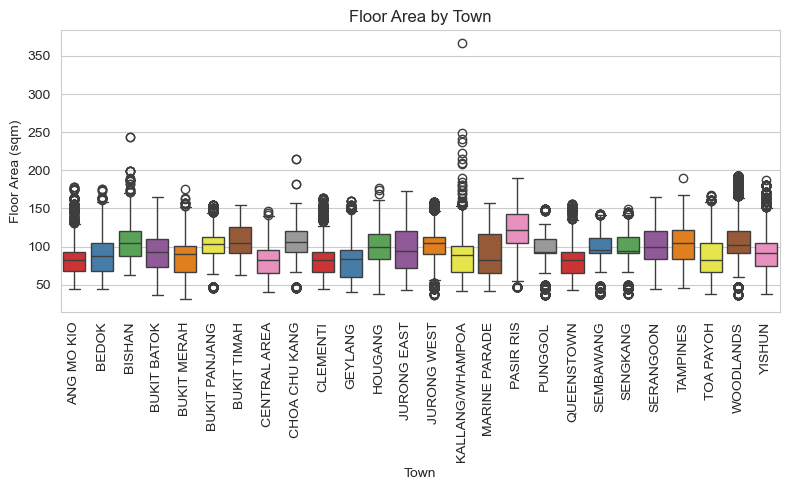

In [107]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town', y='floor_area_sqm', hue='town', palette='Set1')

ax.set_title('Floor Area by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Floor Area (sqm)')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The chart shows that some town contains more outliers than other town in terms of floor area. KALLANG/WHAMPOA has many outliers that goes beyond 200 sqm. These are the 3 Room terrace that we discovered earlier.**

In [108]:
town_breakdown[['resale_price']].describe()

resale_price                                          \
                       count           mean            std       min   
town                                                                   
ANG MO KIO            8629.0  471795.987456  202015.212937  174000.0   
BEDOK                11008.0  473809.727471  177131.630552  180000.0   
BISHAN                3711.0  700576.109070  216339.699790  210000.0   
BUKIT BATOK           8663.0  492623.646833  173341.129299  208000.0   
BUKIT MERAH           8070.0  629909.781492  243424.376194  157000.0   
BUKIT PANJANG         7580.0  494626.395736  139230.050290  200000.0   
BUKIT TIMAH            516.0  766590.426124  249646.409840  300000.0   
CENTRAL AREA          1652.0  681580.699613  312536.648224  200000.0   
CHOA CHU KANG         9566.0  482317.847710  118829.029791  200000.0   
CLEMENTI              4669.0  544380.677875  222786.423191  205000.0   
GEYLANG               5172.0  499431.791914  223315.595467  150000.0   
HOUGANG              10619.0  512552.688344  164544.473429  195000.0   
JURONG EAST           4300.0  467871.519070  159427.284454  200000.0   
JURONG WEST          13949.0  455858.466863  129149.179253  175000.0   
KALLANG/WHAMPOA       6444.0  583402.305947  245218.058706  185000.0   
MARINE PARADE         1288.0  553055.917609  195945.272294  180000.0   
PASIR RIS             6087.0  575181.390320  140049.828564  180000.0   
PUNGGOL              15399.0  535457.675937  123849.430363  225000.0   
QUEENSTOWN            5749.0  629490.037530  259199.480918  182000.0   
SEMBAWANG             6252.0  491284.724549  128637.633114  195000.0   
SENGKANG             17295.0  518620.831664  122674.279409  196000.0   
SERANGOON             3761.0  556648.715469  192430.774513  170000.0   
TAMPINES             14339.0  552010.464599  157768.520033  150000.0   
TOA PAYOH             6710.0  556049.157639  275584.215469  140000.0   
WOODLANDS            14959.0  470734.347232  146702.451937  150000.0   
YISHUN               14395.0  443556.023394  135822.137644  190000.0   

                                                          
                      25%       50%       75%        max  
town                                                      
ANG MO KIO       326888.0  407000.0  570000.0  1500000.0  
BEDOK            338000.0  420000.0  590000.0  1270000.0  
BISHAN           545000.0  680000.0  835000.0  1568000.0  
BUKIT BATOK      355000.0  460000.0  620000.0  1088000.0  
BUKIT MERAH      400000.0  648444.0  818000.0  1588000.0  
BUKIT PANJANG    398000.0  475000.0  578916.0  1100000.0  
BUKIT TIMAH      570000.0  755000.0  925750.0  1501555.0  
CENTRAL AREA     435000.0  552500.0  940000.0  1580000.0  
CHOA CHU KANG    390000.0  480000.0  558000.0   980000.0  
CLEMENTI         363888.0  485000.0  709000.0  1400000.0  
GEYLANG          310000.0  448000.0  670000.0  1310000.0  
HOUGANG          385444.0  480000.0  620000.0  1280000.0  
JURONG EAST      350000.0  438944.0  562222.0  1186800.0  
JURONG WEST      360000.0  450000.0  540000.0   980000.0  
KALLANG/WHAMPOA  363000.0  555000.0  770000.0  1568000.0  
MARINE PARADE    405000.0  485000.0  695750.0  1380000.0  
PASIR RIS        470000.0  555000.0  663000.0  1238000.0  
PUNGGOL          445000.0  520000.0  616944.0  1230000.0  
QUEENSTOWN       375000.0  650000.0  832000.0  1658888.0  
SEMBAWANG        382000.0  480000.0  580000.0   878000.0  
SENGKANG         428000.0  505000.0  596000.0  1058000.0  
SERANGOON        404500.0  520000.0  675000.0  1268000.0  
TAMPINES         430000.0  530000.0  650000.0  1200000.0  
TOA PAYOH        320000.0  480000.0  766213.5  1600000.0  
WOODLANDS        360000.0  447000.0  556900.0  1190000.0  
YISHUN           340000.0  420000.0  528000.0  1288888.0

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_6042/1868857051.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


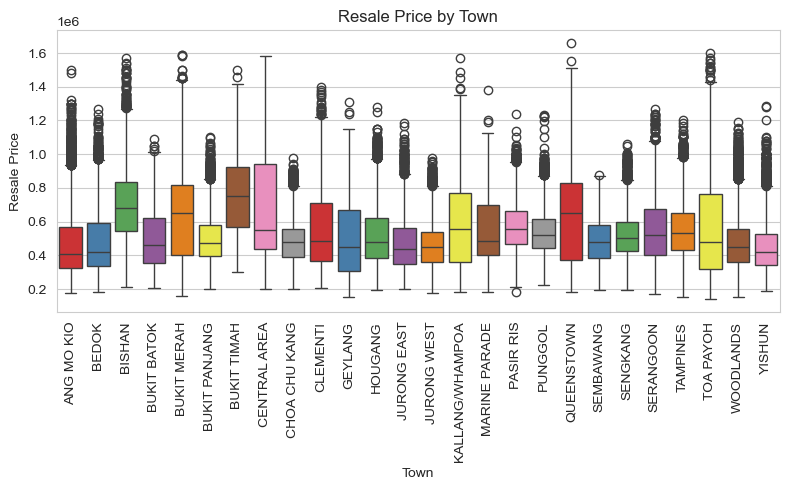

In [109]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town', y='resale_price', hue='town', palette='Set1')

ax.set_title('Resale Price by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

**Some town command higher median selling price compared to other town.**

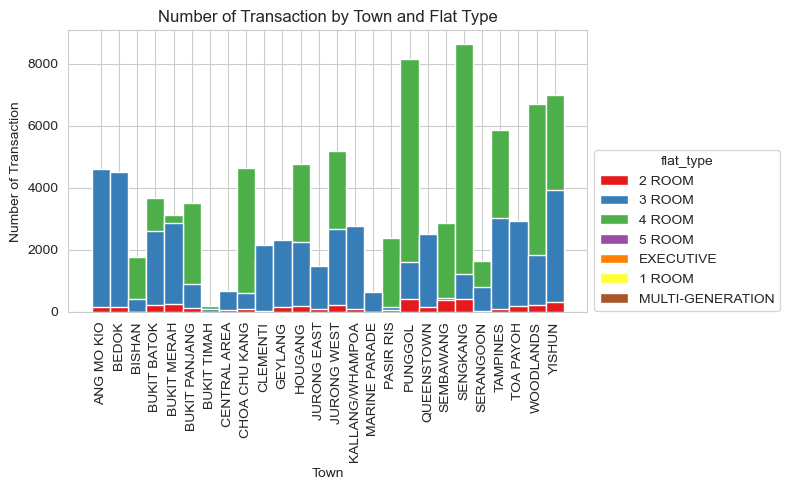

In [110]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town', hue='flat_type', palette='Set1', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Type')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()


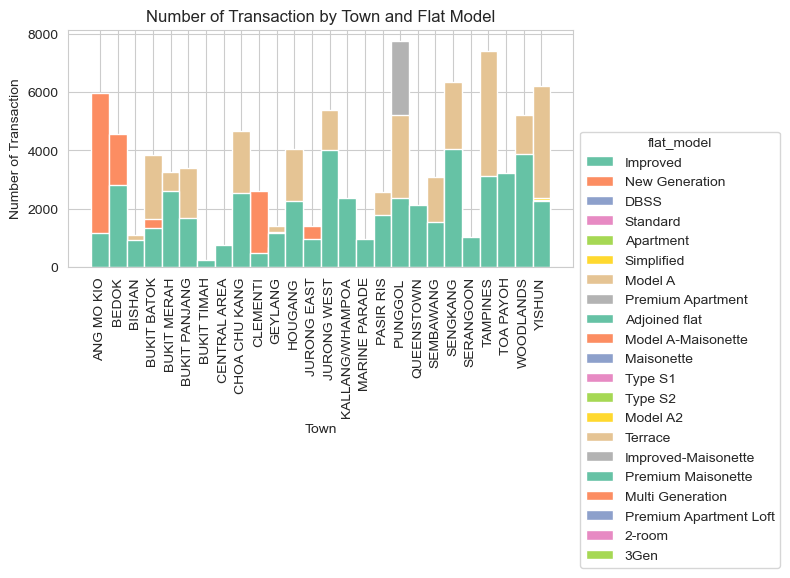

In [111]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town', hue='flat_model', palette='Set2', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Model')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**Some model is only available at some town.**

In [112]:
town_type_breakdown = df[['town', 'flat_type', 'floor_area_sqm', 'resale_price']].groupby(['town', 'flat_type'])
print(town_type_breakdown[['floor_area_sqm']].describe().to_string())



                                 floor_area_sqm                                                           
                                          count        mean        std    min    25%    50%     75%    max
town            flat_type                                                                                 
ANG MO KIO      2 ROOM                    157.0   44.273885   0.636612   44.0   44.0   44.0   44.00   49.0
                3 ROOM                   4603.0   70.988920   5.941121   60.0   67.0   68.0   73.00   89.0
                4 ROOM                   2459.0   92.973160   3.676627   81.0   91.0   92.0   93.50  113.0
                5 ROOM                   1284.0  118.858255   7.187078  110.0  112.0  119.0  121.00  150.0
                EXECUTIVE                 126.0  155.531746   9.120251  142.0  148.0  154.0  163.00  178.0
BEDOK           2 ROOM                    147.0   45.068027   0.816440   44.0   45.0   45.0   45.00   47.0
                3 ROOM               

In [113]:
print(town_type_breakdown[['resale_price']].describe().to_string())

                                 resale_price                                                                                    
                                        count          mean            std       min         25%        50%        75%        max
town            flat_type                                                                                                        
ANG MO KIO      2 ROOM                  157.0  2.532270e+05   44794.230585  178000.0  210000.000   245000.0   293000.0   341000.0
                3 ROOM                 4603.0  3.493004e+05   79175.511759  174000.0  290000.000   340000.0   390000.0   794500.0
                4 ROOM                 2459.0  5.497584e+05  170084.112274  275000.0  420000.000   495000.0   638000.0  1128888.0
                5 ROOM                 1284.0  7.437456e+05  169313.625806  420000.0  615000.000   720000.0   840000.0  1500000.0
                EXECUTIVE               126.0  9.263192e+05  142988.022656  623000.0  8162

**If we breakdown the flat by town and flat type, the dispersion of the floor area and resale price is still wide. But the dispersion of floor area and resale price is narrower compared to just using one classification category. This is due to different flat model.**

In [114]:
full_breakdown = df[['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'resale_price']].groupby(['town', 'flat_type', 'flat_model'])


In [115]:
print(full_breakdown[['floor_area_sqm']].describe().to_string())

                                                        floor_area_sqm                                                            
                                                                 count        mean        std    min     25%    50%     75%    max
town            flat_type        flat_model                                                                                       
ANG MO KIO      2 ROOM           Improved                        157.0   44.273885   0.636612   44.0   44.00   44.0   44.00   49.0
                3 ROOM           Improved                         82.0   61.524390   3.092107   60.0   60.00   60.0   61.00   69.0
                                 Model A                         197.0   68.680203   1.230673   67.0   68.00   68.0   70.00   70.0
                                 New Generation                 4324.0   71.273589   5.941720   67.0   67.00   68.0   73.00   89.0
                4 ROOM           DBSS                            108.0   90.490741 

In [116]:
print(full_breakdown[['resale_price']].describe().to_string())

                                                        resale_price                                                                                     
                                                               count          mean            std        min         25%        50%        75%        max
town            flat_type        flat_model                                                                                                              
ANG MO KIO      2 ROOM           Improved                      157.0  2.532270e+05   44794.230585   178000.0   210000.00   245000.0   293000.0   341000.0
                3 ROOM           Improved                       82.0  3.222456e+05   60229.412254   230000.0   269166.00   330000.0   360000.0   470000.0
                                 Model A                       197.0  5.585788e+05  105251.712666   370000.0   468000.00   550000.0   640000.0   794500.0
                                 New Generation               4324.0  3.4027

**If we breakdown the flat by town, flat type and flat model, for some location, there is no dispersion. However for some location, the dispersion of the floor area and resale price is much narrower compared to previous grouping and classification. However, some flat model still present a slightly wide dispersion in terms of flat model and resale price.**

In [117]:
group_flat_model_sqm = df[['flat_type', 'flat_model', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flat_model', 'floor_area_sqm']).mean()
print(group_flat_model_sqm.to_string())

                                                        resale_price
flat_type        flat_model             floor_area_sqm              
1 ROOM           Improved               31.0            2.098462e+05
2 ROOM           2-room                 37.0            3.093333e+05
                                        38.0            3.473060e+05
                                        40.0            2.650440e+05
                                        42.0            2.950000e+05
                                        43.0            2.990000e+05
                                        44.0            2.976667e+05
                                        46.0            2.870000e+05
                                        47.0            3.512106e+05
                                        48.0            3.759610e+05
                                        55.0            3.012500e+05
                 DBSS                   50.0            3.675000e+05
                 Improved         

**Even if we fine tuned the flat selection by model type, there are many variation in terms of floor area. For example, in a 5 Room Model A flat we have a range of 129 sqm to 157 sqm. This proves that if we narrow our selection to model type, we may not have accurate prediction without the indication of floor area.**

**Our initial conclusion is that the best feature to predict housing price is the floor area. However, we will keep the flat type and flat model to provide us segmentation information so that we can improve the prediction of resale price.**

### Selected Break Down of Resale Price

#### 4 ROOM with Model A by Town

In [118]:
four_model_A = df.loc[(df['flat_type']=='4 ROOM') & (df['flat_model']=='Model A'),['town', 'floor_area_sqm', 'resale_price']]

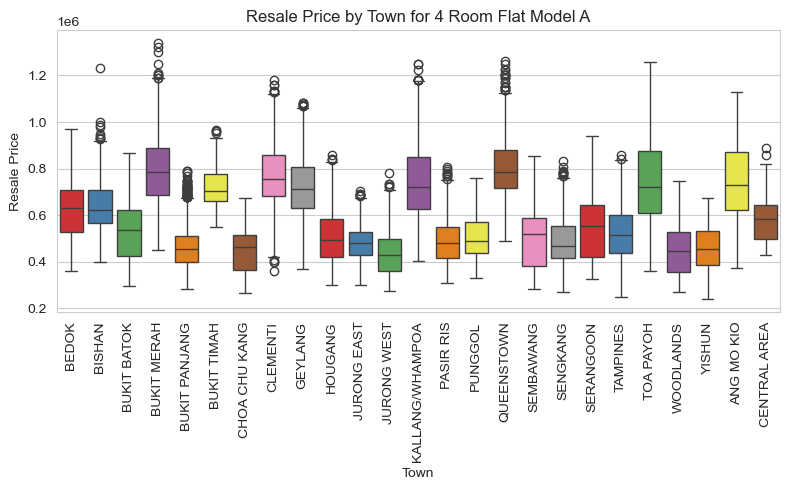

In [119]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=four_model_A, x='town', y='resale_price', hue='town', palette='Set1')

ax.set_title('Resale Price by Town for 4 Room Flat Model A')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The more we breakdown by town, flat type and flat model, the less dispersion is the resale price. However, it is clear that not every town command the same resale price for the same type of flat with the same model.**

### Remaining Lease

In [120]:
df.remaining_lease.unique()

array(['61 years 04 months', '60 years 07 months', '62 years 05 months',
       '62 years 01 month', '63 years', '61 years 06 months',
       '58 years 04 months', '59 years 08 months', '59 years 06 months',
       '60 years', '62 years 08 months', '61 years', '60 years 10 months',
       '59 years 03 months', '61 years 05 months', '60 years 04 months',
       '62 years', '60 years 03 months', '63 years 09 months',
       '61 years 01 month', '61 years 10 months', '58 years 06 months',
       '59 years 04 months', '62 years 11 months', '60 years 08 months',
       '93 years 08 months', '93 years 07 months', '60 years 01 month',
       '94 years 08 months', '78 years 04 months', '60 years 06 months',
       '62 years 06 months', '58 years', '70 years 08 months',
       '63 years 04 months', '63 years 06 months', '67 years 07 months',
       '61 years 07 months', '68 years 02 months', '68 years 03 months',
       '56 years', '67 years 09 months', '67 years 05 months',
       '63 years 07

**Remaining lease is either in year or in year and month. We assume numbers without indicating month or year belongs to year.** 

In [121]:
df.remaining_lease.isnull().sum()

np.int64(0)

**We need to convert the remaining lease to months as a standard indicator.**

In [122]:
def convert_lease_to_month(lease):
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        t_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        t_month = (year * 12)
    else:
        year = int(str_list[0])
        t_month = (year * 12)        
    return t_month

In [123]:
df['remaining_lease_by_month'] = df.remaining_lease.apply(convert_lease_to_month)

### Correlation Analysis

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210782 entries, 0 to 211085
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   month                     210782 non-null  object  
 1   town                      210782 non-null  object  
 2   flat_type                 210782 non-null  object  
 3   storey_range              210782 non-null  float64 
 4   floor_area_sqm            210782 non-null  float64 
 5   flat_model                210782 non-null  object  
 6   lease_commence_date       210782 non-null  int64   
 7   remaining_lease           210782 non-null  object  
 8   resale_price              210782 non-null  float64 
 9   remaining_lease_by_month  210782 non-null  int64   
 10  _log_price                210782 non-null  float64 
 11  floor_bin                 210782 non-null  category
 12  _price_psm                210782 non-null  float64 
 13  area_bin                  210782 n

In [125]:
corr_column = df[['floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
corr_matrix_pear = corr_column.corr(method='pearson')
corr_matrix_pear

floor_area_sqm  lease_commence_date  \
floor_area_sqm                  1.000000             0.101703   
lease_commence_date             0.101703             1.000000   
remaining_lease_by_month        0.111033             0.985837   
resale_price                    0.579277             0.369411   

                          remaining_lease_by_month  resale_price  
floor_area_sqm                            0.111033      0.579277  
lease_commence_date                       0.985837      0.369411  
remaining_lease_by_month                  1.000000      0.308908  
resale_price                              0.308908      1.000000

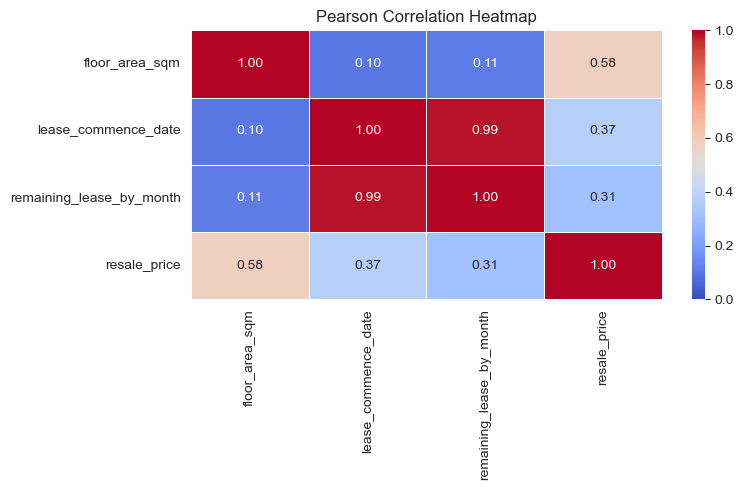

In [126]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(corr_matrix_pear, annot=True, cmap='coolwarm', vmin=0, center=0.5, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Pearson Correlation Heatmap')

plt.tight_layout()
plt.show()

**There is a strong correlation between floor area and resale price. There is also moderate correlation between resale price and lease commence date which in turn indicating the age of the flat. The features, lease commence date and remaining lease in months are highly correlated. Therefore, it is suggested that we either use Ridge Regression to reduce the impact of multicollinearity or we drop one of the feature.** 

In [127]:
spearman_col = df[['storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
spearman_corr = spearman_col.corr(method='spearman')

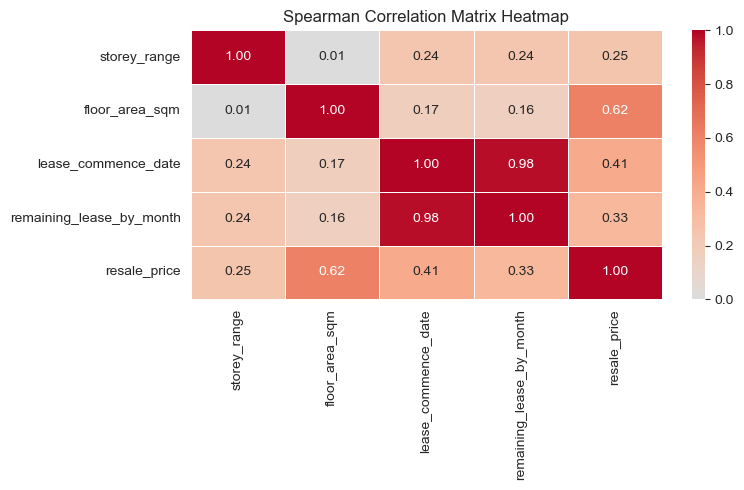

In [128]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=0, center=0, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Spearman Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()

**There is strong correlation between floor area and resale price. Moderate correlation between age of the flat and the resale price. Moderate to weak correlation between height of the flat and resale price. Similarly, there is high correlation between lease commence date and remaining lease in months. Remaining lease in months are slightly more correlated to the resale price, as it is more granular. Therefore, we can consider dropping lease commence date if necessary.**

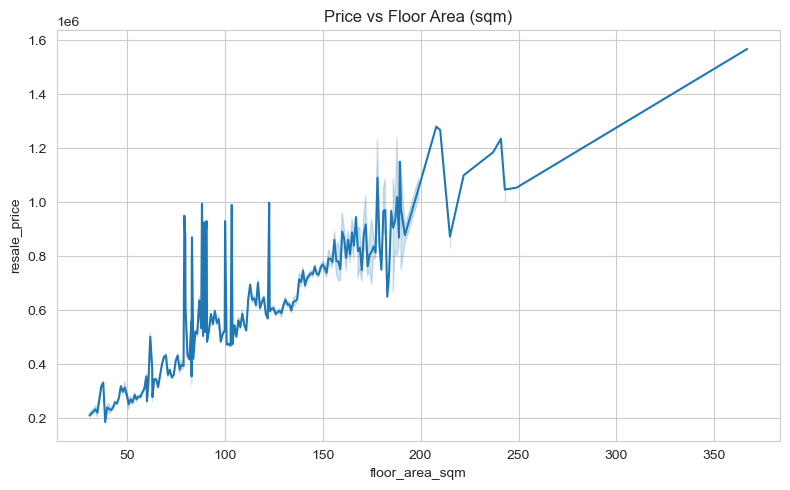

In [129]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(df, x = df.floor_area_sqm, y=df.resale_price)

ax.set_title('Price vs Floor Area (sqm)')

plt.tight_layout()
plt.show()

**There is a linear trend in terms of resale price and its biggest contributor.**

## EDA Findings

### Conclusion

- **Floor area is the most important feature follow by age of the flat and the height of the flat.**
- **For the age of the flat, we will drop the column `lease_commence_date` and keep `remaining_lease_by_month`.** 
- **Other factor that are not in correlation analysis such as location information (`town_name`) also provide important signal on pricing prediction.**
- **We will keep the `flat_type` and `flatm_name` (flat model) to improve the prediction by providing segmental information.**
- **Investigation in our EDA suggested that there are many variation in `flat_type`. For example, a 3-room flat, the floor area ranges from 78sqm to 280 sqm. Therefore, we think that `flat_type` should be nominal instead of ordinal.**
- **Lastly, we will keep transaction year and month, to help with the seasonal resale price prediction.**

## Data Cleaning

In [130]:
# Load the dataset
df = pd.read_csv('./data/hdb_resale_price.csv')

In [131]:
len(df)

211086

### Removing Duplicates

In [132]:
# Remove duplicated items
df.drop_duplicates(inplace=True)

In [133]:
df.duplicated().sum()

np.int64(0)

In [134]:
len(df)

210782

In [135]:
df.describe()

floor_area_sqm  lease_commence_date  resale_price
count   210782.000000        210782.000000  2.107820e+05
mean        96.860812          1996.336770  5.176226e+05
std         24.038202            14.241823  1.828416e+05
min         31.000000          1966.000000  1.400000e+05
25%         82.000000          1985.000000  3.800000e+05
50%         93.000000          1996.000000  4.850000e+05
75%        112.000000          2011.000000  6.200000e+05
max        366.700000          2022.000000  1.658888e+06

## Feature Engineering

### Feature Engineering - Splitting Transaction Column 'month' to Year and Month

In [136]:
# Splitting column 'month' into year and month
df['year_month'] = pd.to_datetime(df.month, format='%Y-%m')
df['transac_year'] = df.year_month.dt.year
df['transac_month'] = df.year_month.dt.month

In [137]:
df.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price year_month  transac_year  transac_month  
0      232000.0 2017-01-01          2017              1  
1      250000.0 2017-01-01          2017              1  
2      262000.0 2017-01-01          2017              1  
3      265000.0 2017-01-01          2017              1  
4      265000.0 2017-01-01          2017              1

### Feature Engineering - Convert 'remaining_lease' to remaining_lease_months'

In [138]:
def convert_lease_to_month(lease: str) -> int:
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        total_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        total_month = (year * 12)
    else:
        year = int(str_list[0])
        total_month = (year * 12)        
    return total_month

In [139]:
# Convert column remaining lease to remaining lease by  months
df['remaining_lease_by_months'] = df.remaining_lease.apply(convert_lease_to_month)


In [140]:

df[['remaining_lease', 'remaining_lease_by_months']].sample(10)

remaining_lease  remaining_lease_by_months
189473  90 years 05 months                       1085
96647   62 years 11 months                        755
133982  94 years 06 months                       1134
179500  59 years 08 months                        716
134354  77 years 06 months                        930
27623   79 years 07 months                        955
141423  61 years 04 months                        736
11097   69 years 11 months                        839
133791            78 years                        936
136495   76 years 01 month                        913

### Feature Engineering - 'storey_range'

In [141]:
def convert_storey_range(storey_range: str) -> float:
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [142]:
# convert storey range to number middle value
df.storey_range = df.storey_range.apply(convert_storey_range)

In [143]:
df.head()

month        town flat_type block        street_name  storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10          11.0   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4           2.0   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5           2.0   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10           5.0   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5           2.0   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price year_month  transac_year  transac_month  \
0      232000.0 2017-01-01          2017              1   
1      250000.0 2017-01-01          2017              1   
2      262000.0 2017-01-01          2017              1   
3      265000.0 2017-01-01          2017              1   
4      265000.0 2017-01-01          2017              1   

   remaining_lease_by_months  
0                        736  
1                        727  
2                        749  
3                        745  
4                        749

### Dropping Irrelevant Columns

In [144]:
# Dropping irrelevant columns for machine learning preparation
irrelevant_columns = ['month', 'block', 'street_name', 'remaining_lease', 'year_month', 'lease_commence_date']
df.drop(columns = irrelevant_columns, inplace=True)

In [145]:
df.head()

town flat_type  storey_range  floor_area_sqm      flat_model  \
0  ANG MO KIO    2 ROOM          11.0            44.0        Improved   
1  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   
2  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   
3  ANG MO KIO    3 ROOM           5.0            68.0  New Generation   
4  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   

   resale_price  transac_year  transac_month  remaining_lease_by_months  
0      232000.0          2017              1                        736  
1      250000.0          2017              1                        727  
2      262000.0          2017              1                        749  
3      265000.0          2017              1                        745  
4      265000.0          2017              1                        749

In [146]:
df.columns

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'resale_price', 'transac_year', 'transac_month',
       'remaining_lease_by_months'],
      dtype='object')

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210782 entries, 0 to 211085
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       210782 non-null  object 
 1   flat_type                  210782 non-null  object 
 2   storey_range               210782 non-null  float64
 3   floor_area_sqm             210782 non-null  float64
 4   flat_model                 210782 non-null  object 
 5   resale_price               210782 non-null  float64
 6   transac_year               210782 non-null  int32  
 7   transac_month              210782 non-null  int32  
 8   remaining_lease_by_months  210782 non-null  int64  
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 14.5+ MB


## Data Split

In [148]:
# Separate the data into features and target
X = df.drop(columns='resale_price')
y = df['resale_price']

In [149]:
X

town         flat_type  storey_range  floor_area_sqm  \
0       ANG MO KIO            2 ROOM          11.0            44.0   
1       ANG MO KIO            3 ROOM           2.0            67.0   
2       ANG MO KIO            3 ROOM           2.0            67.0   
3       ANG MO KIO            3 ROOM           5.0            68.0   
4       ANG MO KIO            3 ROOM           2.0            67.0   
...            ...               ...           ...             ...   
211081      YISHUN         EXECUTIVE           5.0           146.0   
211082      YISHUN         EXECUTIVE           5.0           142.0   
211083      YISHUN         EXECUTIVE           5.0           146.0   
211084      YISHUN  MULTI-GENERATION           5.0           147.0   
211085      YISHUN  MULTI-GENERATION           2.0           171.0   

              flat_model  transac_year  transac_month  \
0               Improved          2017              1   
1         New Generation          2017              1   
2         New Generation          2017              1   
3         New Generation          2017              1   
4         New Generation          2017              1   
...                  ...           ...            ...   
211081        Maisonette          2025              4   
211082         Apartment          2025              5   
211083        Maisonette          2025              7   
211084  Multi Generation          2025              5   
211085  Multi Generation          2025              7   

        remaining_lease_by_months  
0                             736  
1                             727  
2                             749  
3                             745  
4                             749  
...                           ...  
211081                        741  
211082                        741  
211083                        737  
211084                        738  
211085                        738  

[210782 rows x 8 columns]

In [150]:
y

0          232000.0
1          250000.0
2          262000.0
3          265000.0
4          265000.0
            ...    
211081     975000.0
211082    1000000.0
211083     980000.0
211084     945000.0
211085    1095000.0
Name: resale_price, Length: 210782, dtype: float64

In [151]:
# Split the data into training (80%) and test-validation (20%) sets
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=0.5, random_state=42)

In [152]:
# Display the shapes of the splits to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (126469, 8) (126469,)
Validation set shape: (42156, 8) (42156,)
Test set shape: (42157, 8) (42157,)


## Setting Feature Scaling

In [153]:
df.head()

town flat_type  storey_range  floor_area_sqm      flat_model  \
0  ANG MO KIO    2 ROOM          11.0            44.0        Improved   
1  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   
2  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   
3  ANG MO KIO    3 ROOM           5.0            68.0  New Generation   
4  ANG MO KIO    3 ROOM           2.0            67.0  New Generation   

   resale_price  transac_year  transac_month  remaining_lease_by_months  
0      232000.0          2017              1                        736  
1      250000.0          2017              1                        727  
2      262000.0          2017              1                        749  
3      265000.0          2017              1                        745  
4      265000.0          2017              1                        749

In [154]:
# Select columns that are numerical for feature scaling preparation
numerical_features = ['floor_area_sqm', 'remaining_lease_by_months', 'transac_year'] # no lease_commence_date

degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

## Feature Encoding

In [155]:
# Select columns that need to be one-hot encoded
nominal_features = ['transac_month', 'town', 'flat_model', 'flat_type']

# Select the columns that do not required further processing 
passthrough_features = ['storey_range']

# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


## Preprocessor

In [156]:
degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [157]:
# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [158]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [159]:
preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('polynomial_features',
                                                  PolynomialFeatures(degree=1)),
                                                 ('scaler', StandardScaler())]),
                                 ['floor_area_sqm', 'remaining_lease_by_months',
                                  'transac_year']),
                                ('nom',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['transac_month', 'town', 'flat_model',
                                  'flat_type']),
                                ('pass', 'passthrough', ['storey_range'])])

## Model Development

### Multivariate Linear Regression without Target Transformation

In [160]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [161]:
# Model fitting
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town',
                                                   'flat_model', 'flat_type']),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [162]:
# Prediction on validation set
y_val_pred = lr_pipeline.predict(X_val)
y_val_pred

array([386147.68200612, 353506.60106693, 535695.31276344, ...,
       473979.56445228, 582876.55257185, 469617.96133644], shape=(42156,))

In [163]:
# Get feature names after preprocessing
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['num__1' 'num__floor_area_sqm' 'num__remaining_lease_by_months'
 'num__transac_year' 'nom__transac_month_1' 'nom__transac_month_2'
 'nom__transac_month_3' 'nom__transac_month_4' 'nom__transac_month_5'
 'nom__transac_month_6' 'nom__transac_month_7' 'nom__transac_month_8'
 'nom__transac_month_9' 'nom__transac_month_10' 'nom__transac_month_11'
 'nom__transac_month_12' 'nom__town_ANG MO KIO' 'nom__town_BEDOK'
 'nom__town_BISHAN' 'nom__town_BUKIT BATOK' 'nom__town_BUKIT MERAH'
 'nom__town_BUKIT PANJANG' 'nom__town_BUKIT TIMAH'
 'nom__town_CENTRAL AREA' 'nom__town_CHOA CHU KANG' 'nom__town_CLEMENTI'
 'nom__town_GEYLANG' 'nom__town_HOUGANG' 'nom__town_JURONG EAST'
 'nom__town_JURONG WEST' 'nom__town_KALLANG/WHAMPOA'
 'nom__town_MARINE PARADE' 'nom__town_PASIR RIS' 'nom__town_PUNGGOL'
 'nom__town_QUEENSTOWN' 'nom__town_SEMBAWANG' 'nom__town_SENGKANG'
 'nom__town_SERANGOON' 'nom__town_TAMPINES' 'nom__town_TOA PAYOH'
 'nom__town_WOODLANDS' 'nom__town_YISHUN' 'nom__flat_model_2-room'
 'nom__flat

In [164]:
# get model coefficients
model_coefficients = lr_pipeline.named_steps['regressor'].coef_
print(model_coefficients)

[ 0.00000000e+00  1.03069985e+05  7.37293245e+04  8.02113468e+04
 -1.47571796e+04 -1.06721151e+04 -8.08605263e+03 -6.06217746e+02
  2.84816197e+03 -8.10487901e+02 -1.89738541e+02  1.50418762e+03
  3.38279676e+03  5.49076659e+03  1.03457985e+04  1.15500801e+04
  2.50690721e+04  6.86126370e+03  1.22475357e+05 -6.76923622e+04
  1.31304445e+05 -1.13515358e+05  2.28644139e+05  1.29474788e+05
 -1.51664722e+05  5.05704564e+04  6.85580034e+04 -5.94422959e+04
 -5.80389530e+04 -1.14736387e+05  8.83206307e+04  1.62875627e+05
 -7.84283966e+04 -1.06930692e+05  1.36583816e+05 -1.43259419e+05
 -1.20391850e+05  2.78526811e+04 -2.38741653e+04  8.73767986e+04
 -1.34347708e+05 -9.36447696e+04 -1.10182273e+05 -1.01720416e+05
 -2.13432387e+04 -3.71440231e+04  3.72979622e+04 -9.22523141e+04
  1.05868685e+05  3.54000769e+03 -8.65240362e+04  2.87431728e+04
 -7.60579730e+04  2.90691293e+04 -6.58564680e+04 -7.17349022e+04
  2.42664363e+04 -1.16189118e+02 -5.68465687e+04 -8.47575588e+04
  2.53324003e+05  1.46827

In [165]:
# Calculate regression metrics for validation set
lr_val_mae = mean_absolute_error(y_val, y_val_pred)
lr_val_mse = mean_squared_error(y_val, y_val_pred)
lr_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print('Linear Regression Performance Metrics:')
print(f"Linear Regression Validation MAE: {lr_val_mae}")
print(f"Linear Regression Validation MSE: {lr_val_mse}")
print(f"Linear Regression Validation RMSE: {lr_val_rmse}")
print(f"Linear Regression Validation R2: {lr_val_r2}")

Linear Regression Performance Metrics:
Linear Regression Validation MAE: 51370.23165055357
Linear Regression Validation MSE: 4437785962.252212
Linear Regression Validation RMSE: 66616.70933221042
Linear Regression Validation R2: 0.8658877210886544


### Analyzing Residual Plot

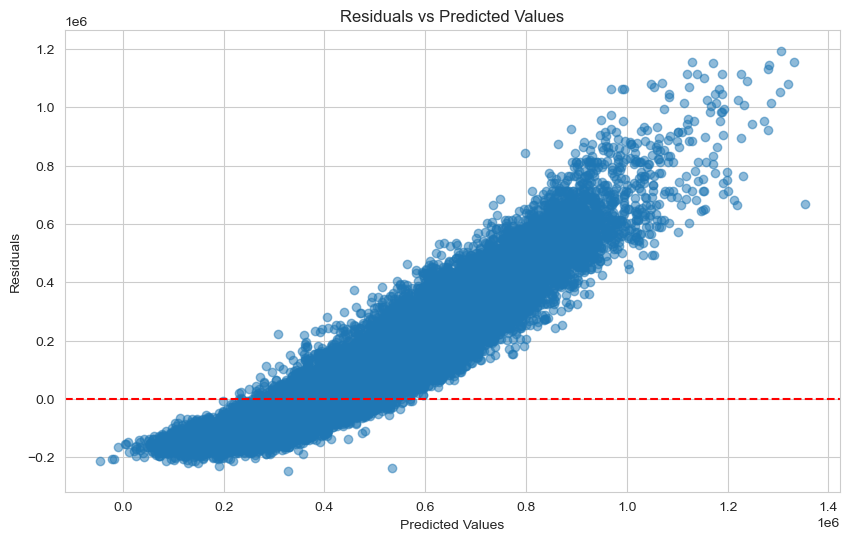

In [166]:
# Residual analysis
residuals = y_val - y_val_pred[0]
# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

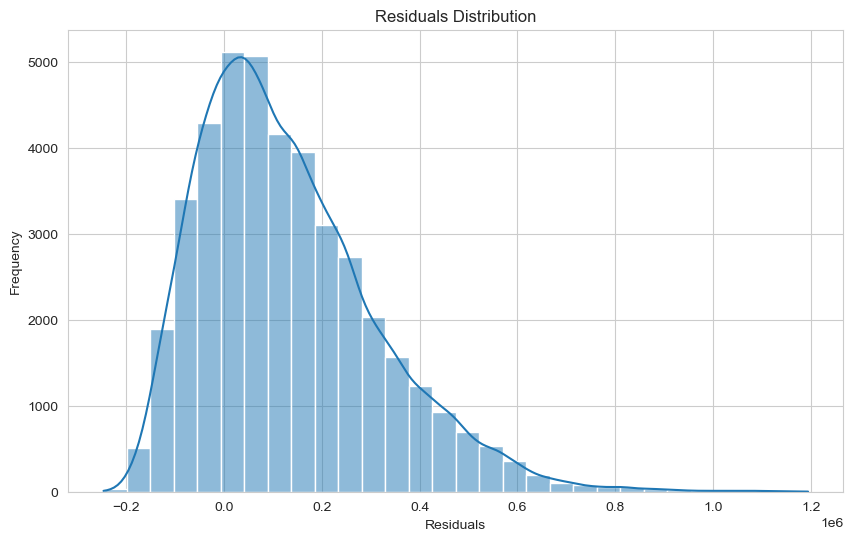

In [167]:
# residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Residual plot shows that the model did not capture non-linearity in the target. Residual distribution remains skewed. Will try target transformation.**

### Multivariate Linear Regression with Target Transformation

In [168]:
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))

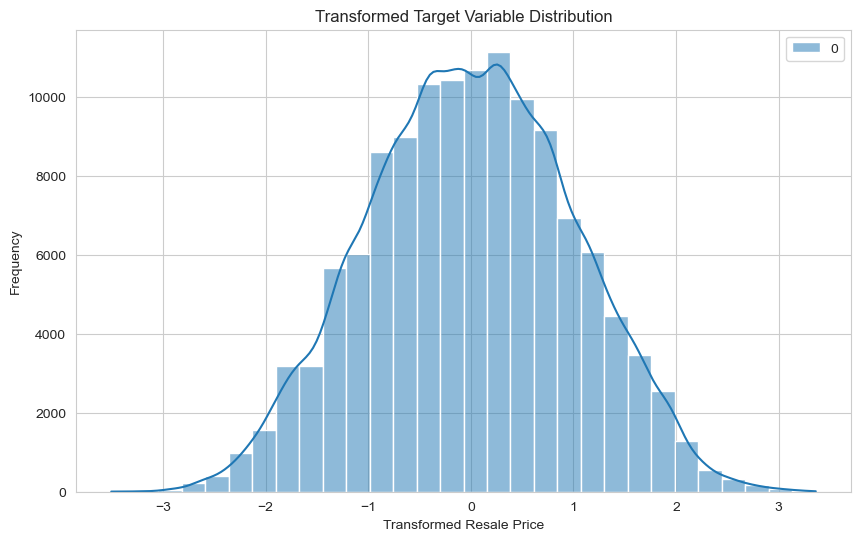

In [169]:
# Plotting the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_train_transformed, kde=True, bins=30)
plt.title('Transformed Target Variable Distribution')
plt.xlabel('Transformed Resale Price')
plt.ylabel('Frequency')
plt.show()

In [170]:
# Model fitting
lr_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town',
                                                   'flat_model', 'flat_type']),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [171]:
# Prediction on validation set
y_val_pred_transformed = lr_pipeline.predict(X_val)
#print(type(y_val_pred_transformed))
#print(y_val_pred_transformed.shape)
y_val_pred = pt.inverse_transform(y_val_pred_transformed.reshape(-1, 1))  # type: ignore # Inverse transform to get original scale

In [172]:
# Calculate regression metrics for validation set
lr_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
lr_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
lr_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2_transformed = r2_score(y_val, y_val_pred)


# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

Validation MAE (Transformed): 43826.703648899216
Validation MSE (Transformed): 3449005363.8729954
Validation RMSE (Transformed): 58728.23310702439
Validation R2 (Transformed): 0.8957692026472335


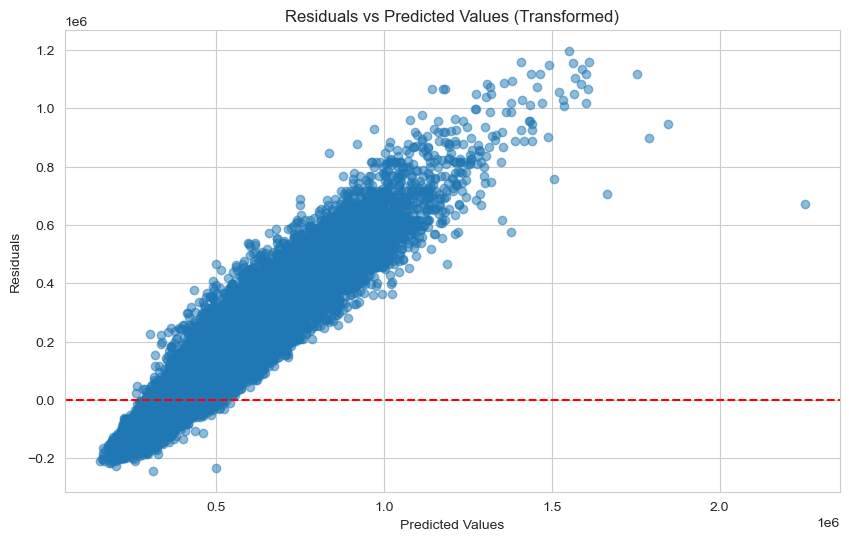

In [173]:
# Residual analysis
residuals = y_val - y_val_pred[0]

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Transformed)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

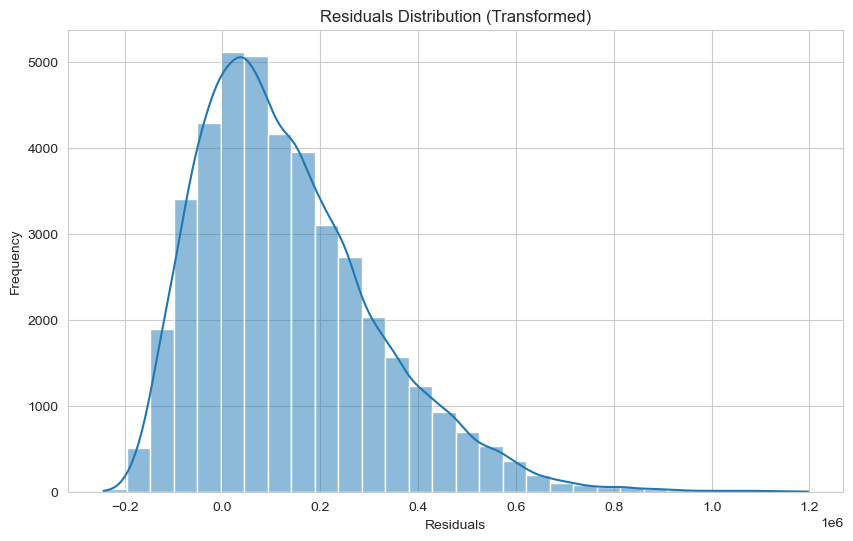

In [174]:
# Residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Transformed)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

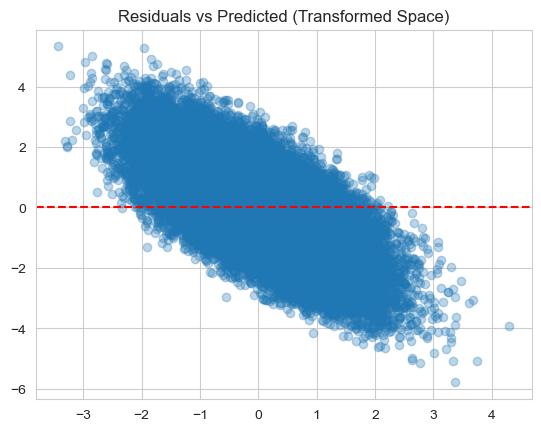

In [175]:
# residual plot in transform space
y_pred_t = lr_pipeline.predict(X_val)          
if isinstance(y_pred_t, tuple):
	y_pred_t_flat = y_pred_t[0].flatten()
else:
	y_pred_t_flat = y_pred_t.flatten()
resid_t = y_train_transformed.flatten()[:len(y_pred_t_flat)] - y_pred_t_flat
plt.scatter(y_pred_t_flat, resid_t, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (Transformed Space)")
plt.show()


**Comparing the residual plot after target transformation, we can see that linear regression could not catch non-linearity.**

In [176]:
# Display the metrics
print(f"Validation MAE: {lr_val_mae}")
print(f"Validation MSE: {lr_val_mse}")
print(f"Validation RMSE: {lr_val_rmse}")
print(f"Validation R2: {lr_val_r2}")

# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

Validation MAE: 51370.23165055357
Validation MSE: 4437785962.252212
Validation RMSE: 66616.70933221042
Validation R2: 0.8658877210886544
Validation MAE (Transformed): 43826.703648899216
Validation MSE (Transformed): 3449005363.8729954
Validation RMSE (Transformed): 58728.23310702439
Validation R2 (Transformed): 0.8957692026472335


The transformation likely helped normalize the error distribution and reduce the impact of large errors (outliers) in the transformed space. This makes the model more accurate on average, leading to a better Mean Absolute Error.

RMSE got worst and there is a slight dip in R-squared due to the inverse transformation. While the model might be performing well in the transformed scale, any prediction errors, particularly those on the higher end of the original data, get magnified when inverse transformed back to the original scale. Since RMSE heavily penalizes these larger errors (by squaring them), it increases. This overall increase in magnified errors also leads to a slight decrease in R-squared, as the model explains less of the variance in the original scale.

Essentially, the transformation optimized for model performance in a normalized space, but the re-scaling back to the original units amplified certain errors, negatively impacting RMSE and R-squared.

**Transformed target did decrease MAE, which is our business objective, residual plot shows that the model failed to capture non-linearity. We will test with Polynomial regression, Ridge and Lasso regression. Will also try Huber Regression and Quantile Regression.**

### Polynomial Regression with/without Transformation

In [177]:
degree = 2  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [178]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [179]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#### Polynomial Regression (No Transformation)

In [180]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town',
                                                   'flat_model', 'flat_type']),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [181]:
y_val_pred = lr_pipeline.predict(X_val)

In [191]:
X_val[0,:]

InvalidIndexError: (0, slice(None, None, None))

In [182]:
# Calculate regression metrics for validation set
poly_val_mae = mean_absolute_error(y_val, y_val_pred)
poly_val_mse = mean_squared_error(y_val, y_val_pred)
poly_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Validation MAE: {poly_val_mae}")
print(f"Validation MSE: {poly_val_mse}")
print(f"Validation RMSE: {poly_val_rmse}")
print(f"Validation R2: {poly_val_r2}")

Validation MAE: 48184.826138295924
Validation MSE: 3920455563.1349926
Validation RMSE: 62613.541371934814
Validation R2: 0.8815217240274792


#### Polynomial Regression (Transformed Target Regressor)

In [183]:
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lr_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred = TransformedTargetRegressor_model.predict(X_val)

In [184]:
# Calculate regression metrics for validation set
poly_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
poly_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
poly_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2_transformed = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Polynomial Regression Validation MAE with {degree} polynomial degree: {poly_val_mae}")
print(f"Polynomial Regression Validation MSE with {degree} polynomial degree: {poly_val_mse}")
print(f"Polynomial Regression Validation RMSE with {degree} polynomial degree: {poly_val_rmse}")
print(f"Polynomial Regression Validation R2 with {degree} polynomial degree: {poly_val_r2}")

# Display the metrics
print(f"Polynomial Regression Validation MAE (Transformed)  with {degree} polynomial degree: {poly_val_mae_transformed}")
print(f"Polynomial Regression Validation MSE (Transformed)  with {degree} polynomial degree: {poly_val_mse_transformed}")
print(f"Polynomial Regression Validation RMSE (Transformed)  with {degree} polynomial degree: {poly_val_rmse_transformed}")
print(f"Polynomial Regression Validation R2 (Transformed)  with {degree} polynomial degree: {poly_val_r2_transformed}")



Polynomial Regression Validation MAE with 2 polynomial degree: 48184.826138295924
Polynomial Regression Validation MSE with 2 polynomial degree: 3920455563.1349926
Polynomial Regression Validation RMSE with 2 polynomial degree: 62613.541371934814
Polynomial Regression Validation R2 with 2 polynomial degree: 0.8815217240274792
Polynomial Regression Validation MAE (Transformed)  with 2 polynomial degree: 42055.281641861846
Polynomial Regression Validation MSE (Transformed)  with 2 polynomial degree: 3184649605.207777
Polynomial Regression Validation RMSE (Transformed)  with 2 polynomial degree: 56432.69978662882
Polynomial Regression Validation R2 (Transformed)  with 2 polynomial degree: 0.9037581758738596


**The results shows that target transformation in polynomial regression did improve the performance slightly.** 

### Ridge Regression

In [185]:
# Setting pipeline for Ridge Regression 
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])


ridge_pipeline.fit(X_train, y_train)
y_val_pred_ridge = ridge_pipeline.predict(X_val)

In [186]:
# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
val_rmse_ridge = root_mean_squared_error(y_val, y_val_pred_ridge)  
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Validation MAE: {val_mae_ridge}")
print(f"Ridge Regression polynomial degree:{degree} MSE: {val_mse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} RMSE: {val_rmse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} R²: {val_r2_ridge}")

Ridge Regression Metrics:
Ridge Regression polynomial degree:2 Validation MAE: 50756.677698764805
Ridge Regression polynomial degree:2 MSE: 4340992148.637018
Ridge Regression polynomial degree:2 RMSE: 65886.20605739125
Ridge Regression polynomial degree:2 R²: 0.8688128822025234


In [187]:
# Target Transformation for Ridge 
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = ridge_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_ridge_transformed = TransformedTargetRegressor_model.predict(X_val)

In [188]:

# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge_transformed = mean_absolute_error(y_val, y_val_pred_ridge_transformed)
val_mse_ridge_transformed = mean_squared_error(y_val, y_val_pred_ridge_transformed)
val_rmse_ridge_transformed = root_mean_squared_error(y_val, y_val_pred_ridge_transformed)  
val_r2_ridge_transformed = r2_score(y_val, y_val_pred_ridge_transformed)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation Validation MAE: {val_mae_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation MSE: {val_mse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation RMSE: {val_rmse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation R²: {val_r2_ridge_transformed}")

Ridge Regression Metrics:
Ridge Regression polynomial degree:2 Target Transformation Validation MAE: 43512.49858540389
Ridge Regression polynomial degree:2 Target Transformation MSE: 3363451620.445826
Ridge Regression polynomial degree:2 Target Transformation RMSE: 57995.272397375855
Ridge Regression polynomial degree:2 Target Transformation R²: 0.8983546827938675


### Lasso Regression

In [189]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = 0.001, max_iter=3000, random_state=42))
])

TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lasso_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_lasso = TransformedTargetRegressor_model.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso_transformed = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso_transformed = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso_transformed = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso_transformed = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Transformed Validation MAE: {val_mae_lasso_transformed}")
print(f"Lasso Transformed Validation MSE: {val_mse_lasso_transformed}")
print(f"Lasso Transformed Validation RMSE: {val_rmse_lasso_transformed}")
print(f"Lasso Transformed Validation R²: {val_r2_lasso_transformed}")

Lasso Regression Metrics:
Lasso Transformed Validation MAE: 44484.35560201912
Lasso Transformed Validation MSE: 3608611873.2543855
Lasso Transformed Validation RMSE: 60071.72274252159
Lasso Transformed Validation R²: 0.8909458080796956


/opt/miniconda3/envs/hdbenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.29274175948194, tolerance: 12.646900000000024
  model = cd_fast.sparse_enet_coordinate_descent(


In [190]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.001, max_iter=3000, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)
y_val_pred_lasso = lasso_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Validation MAE: {val_mae_lasso}")
print(f"Lasso Validation MSE: {val_mse_lasso}")
print(f"Lasso Validation RMSE: {val_rmse_lasso}")
print(f"Lasso Validation R²: {val_r2_lasso}")

Lasso Regression Metrics:
Lasso Validation MAE: 51105.55393584825
Lasso Validation MSE: 4399208210.857664
Lasso Validation RMSE: 66326.52720335707
Lasso Validation R²: 0.8670535614871788


/opt/miniconda3/envs/hdbenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281078252820784.72, tolerance: 423071867607.5596
  model = cd_fast.sparse_enet_coordinate_descent(


### Huber Regression

This is an experiment on Huber Regression as no transformation is required.

In [191]:
degree = 2  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [192]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [193]:
# Setting pipeline for Huber Regression 
huber_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HuberRegressor(epsilon=1.35, max_iter=3000, alpha=0.001)) # usually 1.35 epsilon
])


huber_pipeline.fit(X_train, y_train)
y_val_pred_huber = huber_pipeline.predict(X_val)

In [194]:
# Calculate regression metrics for validation set with Huber Regression
val_mae_huber = mean_absolute_error(y_val, y_val_pred_huber)
val_mse_huber = mean_squared_error(y_val, y_val_pred_huber)
val_rmse_huber = root_mean_squared_error(y_val, y_val_pred_huber)  
val_r2_huber = r2_score(y_val, y_val_pred_huber)

# Display the metrics for Huber Regression
print("Huber Regression Metrics:")
print(f"Huber Validation MAE: {val_mae_huber}")
print(f"Huber Validation MSE: {val_mse_huber}")
print(f"Huber Validation RMSE: {val_rmse_huber}")
print(f"Huber Validation R²: {val_r2_huber}")

Huber Regression Metrics:
Huber Validation MAE: 50682.150714720716
Huber Validation MSE: 4511032174.818349
Huber Validation RMSE: 67164.21796476416
Huber Validation R²: 0.8636741811449921


### Quantile Regression

This is an experiment on Quantile regression to check the performance against traditional linear models.

In [195]:
len(X_train)

126469

In [196]:
# Perform train test split
X_train_q, _, y_train_q, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [ ]:
# Setting pipeline for Quantile Regression (mid quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.5))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_5 = quantile_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_5 = mean_absolute_error(y_val, y_val_pred_quant_5)
val_mse_quant_5 = mean_squared_error(y_val, y_val_pred_quant_5)
val_rmse_quant_5 = root_mean_squared_error(y_val, y_val_pred_quant_5)  
val_r2_quant_5 = r2_score(y_val, y_val_pred_quant_5)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_5}")
print(f"Quantile Validation MSE: {val_mse_quant_5}")
print(f"Quantile Validation RMSE: {val_rmse_quant_5}")
print(f"Quantile Validation R²: {val_r2_quant_5}")

In [ ]:
# Setting pipeline for Quantile Regression (top end quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.9))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_9 = quantile_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_9 = mean_absolute_error(y_val, y_val_pred_quant_9)
val_mse_quant_9 = mean_squared_error(y_val, y_val_pred_quant_9)
val_rmse_quant_9 = root_mean_squared_error(y_val, y_val_pred_quant_9)  
val_r2_quant_9 = r2_score(y_val, y_val_pred_quant_9)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_9}")
print(f"Quantile Validation MSE: {val_mse_quant_9}")
print(f"Quantile Validation RMSE: {val_rmse_quant_9}")
print(f"Quantile Validation R²: {val_r2_quant_9}")

**Quantile and Huber Regression did not outperform traditional linear model. We will compare metric on Polynomial, Ridge and Lasso Regression.**

#### Linear Model Metric Analysis

In [ ]:
# Add metrics to dictionary for each model with category
metrics_poly = {
    "Category": "Original",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae,
    "RMSE": poly_val_rmse,
    "R2":   poly_val_r2,
}

metrics_poly_transformed = {
    "Category": "Target Transformed",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae_transformed,
    "RMSE": poly_val_rmse_transformed,
    "R2":   poly_val_r2_transformed,
}

metrics_ridge = {
    "Category": "Original",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge,
    "RMSE": val_rmse_ridge,
    "R2":   val_r2_ridge,
}

metrics_ridge_transformed = {
    "Category": "Target Transformed",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge_transformed,
    "RMSE": val_rmse_ridge_transformed,
    "R2":   val_r2_ridge_transformed,
}

metrics_lasso = {
    "Category": "Original",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso,
    "RMSE": val_rmse_lasso,
    "R2":   val_r2_lasso,
}

metrics_lasso_transformed = {
    "Category": "Target Transformed",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso_transformed,
    "RMSE": val_rmse_lasso_transformed,
    "R2":   val_r2_lasso_transformed,
}

# Append all metrics dictionaries to the results list
all_results = [
    metrics_poly,
    metrics_ridge,
    metrics_lasso,
    metrics_poly_transformed,
    metrics_ridge_transformed,
    metrics_lasso_transformed
]

# Create DataFrame with multi-level index
results_df = (
    pd.DataFrame(all_results)
      .set_index(["Category", "Model"])
      .round(4)
)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string())

# Alternative: Create separate sections with cleaner display
print("\n" + "="*80)
print("MODEL PERFORMANCE - SEPARATED BY TRANSFORMATION")
print("="*80)

# Group by category and display each section
for category in results_df.index.get_level_values('Category').unique():
    print(f"\n{category.upper()} MODELS:")
    print("-" * 80)
    section_df = results_df.loc[category].round(4)
    print(section_df.to_string())

**Regularization will reduce validation performance, but the difference is not that huge if we are looking at R2 or MAE. We need further fine tuning and apply the model to the test set before we can decide who model to use. However, we will try Decision Tree model since our target are non-linear.** 

### Decision Tree Based Baseline Model

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
# Decision Tree Regressor

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_pipeline.fit(X_train, y_train)   

In [ ]:
# Predict on the validation set with Decision Tree Regressor
y_val_pred_dt = dt_pipeline.predict(X_val)  
# Calculate regression metrics for validation set with Decision Tree Regressor
val_mae_dt = mean_absolute_error(y_val, y_val_pred_dt)
val_mse_dt = mean_squared_error(y_val, y_val_pred_dt)
val_rmse_dt = root_mean_squared_error(y_val, y_val_pred_dt)
val_r2_dt = r2_score(y_val, y_val_pred_dt)  

# Display the metrics for Decision Tree Regressor
print("Decision Tree Regressor Metrics:")
print(f"Decision Tree Validation MAE: {val_mae_dt}")
print(f"Decision Tree Validation MSE: {val_mse_dt}")
print(f"Decision Tree Validation RMSE: {val_rmse_dt}")
print(f"Decision Tree Validation R²: {val_r2_dt}")

In [ ]:
# Display the feature importance
dt_feature_importances = dt_pipeline.named_steps['regressor'].feature_importances_
dt_feature_names = preprocessor.get_feature_names_out()
dt_feature_importances_df = pd.DataFrame({'Feature': dt_feature_names, 'Importance': dt_feature_importances})
dt_feature_importances_df = dt_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("\nDecision Tree Feature Importances (Top 20):")
print(dt_feature_importances_df[:20])  # Display top 20 features

**Using basic decision tree model without any parameter tuning, our error reduced and performance improve is much better than Linear Regression with transformed target. We have a MAE of $33K and R-squared of 92%. We believe that any parameter fine tuning on linear model will not be able to outperform the decision tree base line model. We will stop using linear models and adopt tree-based model as our recommended model.**
 

### Random Forest

In [ ]:
# Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with Random Forest Regressor
y_val_pred_rf = rf_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Random Forest Regressor
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
val_rmse_rf = root_mean_squared_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

# Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {val_mae_rf}")
print(f"Random Forest Validation MSE: {val_mse_rf}")
print(f"Random Forest Validation RMSE: {val_rmse_rf}")
print(f"Random Forest Validation R²: {val_r2_rf}")

In [ ]:
# Display the feature importances for Random Forest
rf_feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_
rf_feature_names = preprocessor.get_feature_names_out()
rf_feature_importances_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importances})
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances for Random Forest
print("\nRandom Forest Feature Importances (Top 20):")
print(rf_feature_importances_df[:20])  # Display top 20 features

### XGBoost

In [ ]:
# XGBoost Regressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])
xgb_pipeline.fit(X_train, y_train)  

In [ ]:
# predict on the validation set with XGBoost Regressor
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with XGBoost Regressor
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
val_mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
val_rmse_xgb = root_mean_squared_error(y_val, y_val_pred_xgb)
val_r2_xgb = r2_score(y_val, y_val_pred_xgb)

# Display the metrics for XGBoost Regressor
print("XGBoost Regressor Metrics:")
print(f"XGBoost Validation MAE: {val_mae_xgb}")
print(f"XGBoost Validation MSE: {val_mse_xgb}")
print(f"XGBoost Validation RMSE: {val_rmse_xgb}")
print(f"XGBoost Validation R²: {val_r2_xgb}")

In [ ]:
# Display the feature importances of XGBoost
xgb_feature_importances = xgb_pipeline.named_steps['regressor'].feature_importances_
xgb_feature_names = preprocessor.get_feature_names_out()
xgb_feature_importances_df = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_feature_importances})
xgb_feature_importances_df = xgb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances of XGBoost
print("\nXGBoost Feature Importances (Top 20):")
print(xgb_feature_importances_df[:20])  # Display top 20 features   

### LightGBM

In [ ]:
# LightGBM Regressor
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1))
])
lgb_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with LightGBM Regressor
y_val_pred_lgb = lgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with LightGBM Regressor
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
val_mse_lgb = mean_squared_error(y_val, y_val_pred_lgb)
val_rmse_lgb = root_mean_squared_error(y_val, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val, y_val_pred_lgb)

# Display the metrics for LightGBM Regressor
print("LightGBM Regressor Metrics:")
print(f"LightGBM Validation MAE: {val_mae_lgb}")
print(f"LightGBM Validation MSE: {val_mse_lgb}")
print(f"LightGBM Validation RMSE: {val_rmse_lgb}")
print(f"LightGBM Validation R²: {val_r2_lgb}")

In [ ]:
# Display the feature importances of LightGBM
lgb_feature_importances = lgb_pipeline.named_steps['regressor'].feature_importances_
lgb_feature_names = preprocessor.get_feature_names_out()
lgb_feature_importances_df = pd.DataFrame({'Feature': lgb_feature_names, 'Importance': lgb_feature_importances})
lgb_feature_importances_df = lgb_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances of LightGBM
print("\nLightGBM Feature Importances (Top 20):")
print(lgb_feature_importances_df[:20])  # Display top 20 features

In [ ]:
# add ing metrics to dictionary for each model
metrics_dt = {
    "Model": "Decision Tree",
    "MAE":  val_mae_dt,
    "RMSE": val_rmse_dt,
    "R2":   val_r2_dt,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb,
    "RMSE": val_rmse_lgb,
    "R2":   val_r2_lgb,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf,
    "RMSE": val_rmse_rf,
    "R2":   val_r2_rf,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb,
    "RMSE": val_rmse_xgb,
    "R2":   val_r2_xgb,
}


all_results = [metrics_dt, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

In [ ]:
# Saved for final sanity check
dt_default_model = dt_pipeline
rf_default_model = rf_pipeline

**Without any parameters tuning, Random Forest shows the most promising results, followed by XGBoost and LightGBM. We will use the 3 models for further hyperparameter tuning. Decision tree without tuning will be the base line model for sanity check.** 

## Performance Metrics

In [ ]:
display(results_df)

**MSE is too difficult to interpret and thus we have dropped it from the analysis. We will be using MAE, RMSE and R-squared. We should look at all the different performance metrics MAE, RMSE and R2 because different performance metric present different information. MAE measure the magnitude of errors but it is less sensitive to outliers. RMSE penalized large errors and helps to identify if you have large outliers. R2 tell us how much of the variation in the target are explainable by our model. However, it cannot tell us if the predictions are bias.**

**Our analysis above shows that RMSE and larger than MAE indicating that there are outliers that RMSE amplified. We will not use RMSE as we do not want to penalized the squared error since the outliers are the high end housing market that our property firm would want to served. Our R-squared are consistently high indicating that our tree-based models can explain the variation in the target better. However, the differences between difference R-squared could not help us to explain the metrics further. In conclusion, we would use MAE as our primary metrics as it is also easier to explained to the management of the property firm.**   

## Hyperparameter Tuning

**Grid Search Strategy**

We will use **MAE** as the main metric because it is most easy to be understood by the stakeholder.

We have performed fine tuning with a 3 stage parameters fine tuning starting with **Randomized Search** for stage 1 using the widest search space. Then we will use **Halving Randomized Search** based on the search result of stage 1 and finally, we will use **Optuna Search** to finalized the search parameters.

However, after several hours of fine tuning, our MAE did improved a few hundred dollars. This is not acceptable as the improvement is marginal compared to the resource we have put in. Thus we will be using randomized search  with ranges around the default as sanity check.

For further fine tuning, we will be using optuna with 5 cross validation folder around our searched parameters.

### Random Search CV Parameters Settings

In [ ]:
# Define RansomizedSearchCV parameters with wide search space for Decision Tree Regressor, Random Forest Regressor, XGBoost Regressor, and LightGBM Regressor

rf_param_grid = {
    'regressor__n_estimators':    [100, 200, 300],       
    'regressor__max_depth':       [40, 50, 60],           
    'regressor__min_samples_split': [2, 5, 7, 10],
    'regressor__min_samples_leaf':  [1, 5, 7, 10],
    'regressor__max_features':      ['sqrt', 'log2', 0.5, 1.0]
}   

xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],      
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}   

lgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__num_leaves': [31, 63, 127],
    'regressor__min_child_samples': [20, 30, 40],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}


In [ ]:
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

In [ ]:
# perform randomized search for XGBoost Regressor
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=60,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',   
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
xgb_random_search.fit(X_train, y_train) 

In [ ]:
# perform randomized search for LightGBM Regressor
lgb_random_search = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=lgb_param_grid,
    n_iter=30,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',       
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
lgb_random_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", rf_random_search.best_params_)
print("Best score for Random Forest Regressor (negative MSE):", rf_random_search.best_score_)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", xgb_random_search.best_params_)
print("Best score for XGBoost Regressor (negative MSE):", xgb_random_search.best_score_)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", lgb_random_search.best_params_)
print("Best score for LightGBM Regressor (negative MSE):", lgb_random_search.best_score_)

**The difference between the best model is not that great. Will perform fine tuning and select the best few for final model evaluation test.**

### Optuna Grid Search CV

In [ ]:
def make_tight_distributions(best_params,
                             int_frac: float = 0.2,
                             float_frac: float = 0.1,
                             min_int_step: int = 1):
    """
    Given a dict of best_params_, return a dict of
    Optuna Distributions that span ±frac around each value.
    """
    tight_dists = {}
    for name, val in best_params.items():
        # only handle numeric params
        if isinstance(val, int):
            # window = max(val * int_frac, min_int_step)
            window = max(int(val * int_frac), min_int_step)
            low  = max(1, val - window)      # avoid zero or negative
            high = val + window
            # choose step = min_int_step or window itself
            step = min_int_step if min_int_step <= window else window
            tight_dists[name] = IntDistribution(low=low, high=high, step=step)

        elif isinstance(val, float):
            window = val * float_frac
            low  = max(0.0, val - window)
            high = min(1.0, val + window)    # assuming [0,1] support for fractions
            tight_dists[name] = FloatDistribution(low=low, high=high)

        else:
            # skip non-numeric (e.g. categorical) or handle separately
            continue

    return tight_dists


#### Random Forest Optuna Search CV

In [ ]:

# 1. grab your previously-found best params:
best_rf_random_search = rf_random_search.best_params_

# 2. build the “around-the-best” distributions:
rf_param_distributions = make_tight_distributions(best_rf_random_search,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
rf_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    cv=5,             
    n_trials=2,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)


In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_rf_model = optuna_search.best_estimator_
final_rf_model_params = optuna_search.best_params_
final_rf_model_scores = optuna_search.best_score_

In [ ]:
val_final_rf_model_pred = final_rf_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_rf = mean_absolute_error(y_val, val_final_rf_model_pred)
final_val_mse_rf = mean_squared_error(y_val, val_final_rf_model_pred)
final_val_rmse_rf = root_mean_squared_error(y_val, val_final_rf_model_pred)
final_val_r2_rf = r2_score(y_val, val_final_rf_model_pred)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_rf}")
print(f"Random Forest Validation MSE: {final_val_mse_rf}")
print(f"Random Forest Validation RMSE: {final_val_rmse_rf}")
print(f"Random Forest Validation R²: {final_val_r2_rf}")

#### XGBoost Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_xgb_random_search_param = xgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
xgb_param_distributions = make_tight_distributions(best_xgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
xgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    cv=5,             
    n_trials=50,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_xgb_model = optuna_search.best_estimator_
final_xgb_model_params = optuna_search.best_params_
final_xgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_xgb_model = final_xgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_xgb = mean_absolute_error(y_val, val_final_xgb_model)
final_val_mse_xgb = mean_squared_error(y_val, val_final_xgb_model)
final_val_rmse_xgb = root_mean_squared_error(y_val, val_final_xgb_model)
final_val_r2_xgb = r2_score(y_val, val_final_xgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_xgb}")
print(f"Random Forest Validation MSE: {final_val_mse_xgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_xgb}")
print(f"Random Forest Validation R²: {final_val_r2_xgb}")

#### Light GBM Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_lgb_random_search_param = lgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
lgb_param_distributions = make_tight_distributions(best_lgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1

In [ ]:
lgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=lgb_pipeline,
    param_distributions=lgb_param_distributions,
    cv=5,             
    n_trials=30,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v!r}")

# 6. Your final model
final_lgb_model = optuna_search.best_estimator_
final_lgb_model_params = optuna_search.best_params_
final_lgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_lgb_model = final_lgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_lgb = mean_absolute_error(y_val, val_final_lgb_model)
final_val_mse_lgb = mean_squared_error(y_val, val_final_lgb_model)
final_val_rmse_lgb = root_mean_squared_error(y_val, val_final_lgb_model)
final_val_r2_lgb = r2_score(y_val, val_final_lgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_lgb}")
print(f"Random Forest Validation MSE: {final_val_mse_lgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_lgb}")
print(f"Random Forest Validation R²: {final_val_r2_lgb}")

#### Comparing Fine Tuned Scores

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", final_rf_model_params)
print("Best score for Random Forest Regressor (negative MSE):", final_rf_model_scores)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", final_xgb_model_params)
print("Best score for XGBoost Regressor (negative MSE):", final_xgb_model_scores)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", final_lgb_model_params)
print("Best score for LightGBM Regressor (negative MSE):", final_lgb_model_scores)


### Evaluation of Fine Tuned Models

**First, we apply the default decision tree as baseline for sanity check.**

In [ ]:
# Predict on the validation set with the default Decision Tree Regressor
y_val_pred_dt_default = dt_default_model.predict(X_val)
# Calculate regression metrics for validation set with the default Decision Tree Regressor
val_mae_dt_default = mean_absolute_error(y_val, y_val_pred_dt_default)
val_rmse_dt_default = root_mean_squared_error(y_val, y_val_pred_dt_default)
val_r2_dt_default = r2_score(y_val, y_val_pred_dt_default)

# Display the metrics for the default Decision Tree Regressor
print("Default Decision Tree Regressor Metrics:")
print(f"Default Decision Tree Validation MAE: {val_mae_dt_default}")
print(f"Default Decision Tree Validation RMSE: {val_rmse_dt_default}")
print(f"Default Decision Tree Validation R²: {val_r2_dt_default}")

**Next, we try Random Forest with default settings as it has a good score before fine tuning.**

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_val_pred_rf_default = rf_default_model.predict(X_val)
# Calculate regression metrics for test set with the default Random Forest Regressor
val_mae_rf_default = mean_absolute_error(y_val, y_val_pred_rf_default)
val_rmse_rf_default = root_mean_squared_error(y_val, y_val_pred_rf_default)
val_r2_rf_default = r2_score(y_val, y_val_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Validation MAE: {val_mae_rf_default}")
print(f"Default Random Forest Validation RMSE: {val_rmse_rf_default}")
print(f"Default Random Forest Validation R²: {val_r2_rf_default}")

In [ ]:
# predict on the validation set with the best Random Forest Regressor
y_val_pred_rf_best = final_rf_model.predict(X_val)
# Calculate regression metrics for validation set with the best Random Forest Regressor
val_mae_rf_best = mean_absolute_error(y_val, y_val_pred_rf_best)
val_rmse_rf_best = root_mean_squared_error(y_val, y_val_pred_rf_best)
val_r2_rf_best = r2_score(y_val, y_val_pred_rf_best)    

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Validation MAE: {val_mae_rf_best}")
print(f"Best Random Forest Validation RMSE: {val_rmse_rf_best}")
print(f"Best Random Forest Validation R²: {val_r2_rf_best}")

In [ ]:
# predict on the validation set with the best xgboost Regressor
y_val_pred_xgb_best = final_xgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best XGBoost Regressor
val_mae_xgb_best = mean_absolute_error(y_val, y_val_pred_xgb_best)
val_rmse_xgb_best = root_mean_squared_error(y_val, y_val_pred_xgb_best)
val_r2_xgb_best = r2_score(y_val, y_val_pred_xgb_best)  
# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Validation MAE: {val_mae_xgb_best}")       
print(f"Best XGBoost Validation RMSE: {val_rmse_xgb_best}")
print(f"Best XGBoost Validation R²: {val_r2_xgb_best}") 


In [ ]:
# predict on the validation set with the best lightgbm Regressor
y_val_pred_lgb_best = final_lgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best LightGBM Regressor
val_mae_lgb_best = mean_absolute_error(y_val, y_val_pred_lgb_best)
val_rmse_lgb_best = root_mean_squared_error(y_val, y_val_pred_lgb_best)
val_r2_lgb_best = r2_score(y_val, y_val_pred_lgb_best)
# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Validation MAE: {val_mae_lgb_best}")
print(f"Best LightGBM Validation RMSE: {val_rmse_lgb_best}")
print(f"Best LightGBM Validation R²: {val_r2_lgb_best}")    


In [ ]:
# add ing metrics to dictionary for each model
metrics_rf_default = {
    "Model": "Random Forest (def)",
    "MAE":  val_mae_rf_default,
    "RMSE": val_rmse_rf_default,
    "R2":   val_r2_rf_default,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf_best,
    "RMSE": val_rmse_rf_best,
    "R2":   val_r2_rf_best,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb_best,
    "RMSE": val_rmse_xgb_best,
    "R2":   val_r2_xgb_best,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb_best,
    "RMSE": val_rmse_lgb_best,
    "R2":   val_r2_lgb_best,
}

all_results = [metrics_rf_default, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

**Our best model is XGBoost with MAE of $23,338 margin or errors.**

**All MAE are very close. In our experience, model with the best validation score may not do well in the test. Therefore, we will apply all the 4 models into the test set. We will deploy model with the best score.**



## Final Model Evaluation

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_test_pred_rf_default = rf_default_model.predict(X_test)
# Calculate regression metrics for test set with the default Random Forest Regressor
test_mae_rf_default = mean_absolute_error(y_test, y_test_pred_rf_default)
test_rmse_rf_default = root_mean_squared_error(y_test, y_test_pred_rf_default)
test_r2_rf_default = r2_score(y_test, y_test_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Test MAE: {test_mae_rf_default}")
print(f"Default Random Forest Test RMSE: {test_rmse_rf_default}")
print(f"Default Random Forest Test R²: {test_r2_rf_default}")

In [ ]:
# Predict on the test set with the best Random Forest Regressor
y_test_pred_rf_best = final_rf_model.predict(X_test)
# Calculate regression metrics for test set with the best Random Forest Regressor
test_mae_rf_best = mean_absolute_error(y_test, y_test_pred_rf_best)
test_rmse_rf_best = root_mean_squared_error(y_test, y_test_pred_rf_best)
test_r2_rf_best = r2_score(y_test, y_test_pred_rf_best)

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Test MAE: {test_mae_rf_best}")
print(f"Best Random Forest Test RMSE: {test_rmse_rf_best}")
print(f"Best Random Forest Test R²: {test_r2_rf_best}")

In [ ]:
# Predict on the test set with the best XGBoost Regressor
y_test_pred_xgb_best = final_xgb_model.predict(X_test)
# Calculate regression metrics for test set with the best XGBoost Regressor
test_mae_xgb_best = mean_absolute_error(y_test, y_test_pred_xgb_best)
test_rmse_xgb_best = root_mean_squared_error(y_test, y_test_pred_xgb_best)
test_r2_xgb_best = r2_score(y_test, y_test_pred_xgb_best)

# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Regressor Test MAE: {test_mae_xgb_best}")
print(f"Best XGBoost Regressor Test RMSE: {test_rmse_xgb_best}")
print(f"Best XGBoost Regressor Test R²: {test_r2_xgb_best}")

In [ ]:
# Predict on the test set with the best LightGBM Regressor
y_test_pred_lgb_best = final_lgb_model.predict(X_test)
# Calculate regression metrics for test set with the best LightGBM Regressor
test_mae_lgb_best = mean_absolute_error(y_test, y_test_pred_lgb_best)
test_rmse_lgb_best = root_mean_squared_error(y_test, y_test_pred_lgb_best)
test_r2_lgb_best = r2_score(y_test, y_test_pred_lgb_best)

# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Regressor Test MAE: {test_mae_lgb_best}")
print(f"Best LightGBM Regressor Test RMSE: {test_rmse_lgb_best}")
print(f"Best LightGBM Regressor Test R²: {test_r2_lgb_best}")

**The best model is still XGBoost. MAE result is similar to validation test. This confirms that our test set is representative of the validation datasets.**

### Final Model Application

In [ ]:
# Best model from Optuna Search
best_model = final_xgb_model

# Predict on the test set with Ridge Regression
y_test_pred_best_model = best_model.predict(X_test)

# Calculate regression metrics for the test set for Ridge
test_mae_best = mean_absolute_error(y_test, y_test_pred_best_model)
test_rmse_best = root_mean_squared_error(y_test, y_test_pred_best_model)
test_r2_best = r2_score(y_test, y_test_pred_best_model)

print("Best Ridge Regression Model, Final Test Metrics:")
print(f"Final Test MAE: {test_mae_best}")
print(f"Final Test RMSE: {test_rmse_best}")
print(f"Final Test R²: {test_r2_best}")

## END